# NES vs NLS (cytosol vs nucleus) classification baselines

Baseline classification methods for classifying sequences to be in or outside of the nucleus

In [55]:
import os
import sys
import warnings
import itertools
import pickle
import copy
import time
import shutil
import importlib
import collections
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    DEVICE = torch.device("cuda:3")
else:
    print("CPU")
    DEVICE = torch.device("cpu")

import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import seq
import pwm

MODEL_DIR = os.path.join(os.path.dirname(SRC_DIR), "jupyter/nls_vs_nes/models")
assert os.path.isdir(MODEL_DIR)

plt.style.use(['default', os.path.join(SRC_DIR, 'seaborn-paper-custom.mplstyle')])
PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

np.random.seed(27492)
SEED = 27492

GeForce GTX 1080 Ti


## Networks based on one-hot encoded sequence (tail 1000bp)

In [2]:
ModelPerf = collections.namedtuple('ModelPerf', ['auroc', 'accuracy', 'recall', 'precision', 'f1'])

def single_train(model, train_data, valid_data):
    """
    Train the model on training data and report results
    train_data and valid_data should be tuples of (x, y)
    """
    print(type(model))
    model.fit(*train_data)

    validation_probs = model.predict_proba(valid_data[0])[:, 1]
    validation_preds = model.predict(valid_data[0])
    
    retval = ModelPerf(
        auroc=metrics.roc_auc_score(valid_data[1].flatten(), validation_probs),
        accuracy=metrics.accuracy_score(valid_data[1], validation_preds),
        recall=metrics.recall_score(valid_data[1], validation_preds),
        precision=metrics.precision_score(valid_data[1], validation_preds),
        f1=metrics.f1_score(valid_data[1], validation_preds),
    )
    
    print("AUC:\t", retval.auroc)
    print("Acc:\t", retval.accuracy)
    print("Rec:\t", retval.recall)
    print("Prec:\t", retval.precision)
    print("F1:\t", retval.f1)
    return retval

importlib.reload(data_loader)  # For reloading when developing the data_loader module
train_data = data_loader.NLSvNESDataset('train', fixed_seq_len=1000)
valid_data = data_loader.NLSvNESDataset('valid', fixed_seq_len=1000)
test_data = data_loader.NLSvNESDataset('test', fixed_seq_len=1000)

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

In [3]:
# Some general metrics about the data
print(train_data[0][0].shape)
print(valid_data[0][0].shape)
print(test_data[0][0].shape)
# print("Shape of training input:", train_data_full[0].shape)
# print("Shape of validation input:", valid_data_full[0].shape)

torch.Size([1000, 4])
torch.Size([1000, 4])
torch.Size([1000, 4])


In [2]:
class FactorizedBasset(nn.Module):
    """
    This model is known to do well in predicting transcription factor binding. This means it may be good
    at predicting sequence localization as well, if its architecture lends itself well to predicting sequence
    motifs in general.
    """
    def __init__(self, dropout, num_classes=2):
        super(FactorizedBasset, self).__init__()
        torch.manual_seed(3278)

        self.dropout = dropout
        self.num_cell_types = num_classes
        if self.num_cell_types != 2:
            raise NotImplementedError

        self.layer1 = self.layer_one()
        self.layer2 = self.layer_two()
        self.layer3 = self.layer_three()
        self.maxpool1 = nn.MaxPool2d((3, 1))
        self.maxpool2 = nn.MaxPool2d((4, 1))
        self.maxpool3 = nn.MaxPool2d((4, 1))
        self.fc1 = nn.Linear(4200, 1000)
        self.bn4 = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.bn5 = nn.BatchNorm1d(1000)
        # self.fc3 = nn.Linear(1000, self.num_cell_types)
        self.fc3 = nn.Linear(1000, 1)

    def layer_one(self):
        self.conv1a = nn.Conv2d(4, 48, (3, 1), stride=(1, 1), padding=(1, 0))
        self.conv1b = nn.Conv2d(48, 64, (3, 1), stride=(1, 1), padding=(1, 0))
        self.conv1c = nn.Conv2d(64, 100, (3, 1), stride=(1, 1), padding=(1, 0))
        self.conv1d = nn.Conv2d(100, 150, (7, 1), stride=(1, 1), padding=(3, 0))
        self.conv1e = nn.Conv2d(150, 300, (7, 1), stride=(1, 1), padding=(3, 0))

        self.bn1a = nn.BatchNorm2d(48)
        self.bn1b = nn.BatchNorm2d(64)
        self.bn1c = nn.BatchNorm2d(100)
        self.bn1d = nn.BatchNorm2d(150)
        self.bn1e = nn.BatchNorm2d(300)

        tmp = nn.Sequential(self.conv1a, self.bn1a, nn.ReLU(inplace=True),
                            self.conv1b, self.bn1b, nn.ReLU(inplace=True),
                            self.conv1c, self.bn1c, nn.ReLU(inplace=True),
                            self.conv1d, self.bn1d, nn.ReLU(inplace=True),
                            self.conv1e, self.bn1e, nn.ReLU(inplace=True))

        return tmp

    def layer_two(self):
        self.conv2a = nn.Conv2d(300, 200, (7,1), stride = (1,1), padding = (3,0))
        self.conv2b = nn.Conv2d(200, 200, (3,1), stride = (1,1), padding = (1, 0))
        self.conv2c = nn.Conv2d(200, 200, (3, 1), stride =(1,1), padding = (1,0))

        self.bn2a = nn.BatchNorm2d(200)
        self.bn2b = nn.BatchNorm2d(200)
        self.bn2c = nn.BatchNorm2d(200)

        tmp = nn.Sequential(self.conv2a,self.bn2a, nn.ReLU(inplace= True),
                            self.conv2b,self.bn2b, nn.ReLU(inplace=True),
                            self.conv2c, self.bn2c, nn.ReLU(inplace=True))
        return tmp

    def layer_three(self):
        self.conv3 = nn.Conv2d(200, 200, (7,1), stride =(1,1), padding = (4,0))
        self.bn3 = nn.BatchNorm2d(200)
        return nn.Sequential(self.conv3, self.bn3, nn.ReLU(inplace=True))

    def forward(self, s):
        """Expect input batch_size x 1000 x 4"""
        s = s.permute(0, 2, 1).contiguous()  # batch_size x 4 x 1000
        s = s.view(-1, 4, 1000, 1)  # batch_size x 4 x 1000 x 1 [4 channels]
        s = self.maxpool1(self.layer1(s)) # batch_size x 300 x 333 x 1
        s = self.maxpool2(self.layer2(s)) # batch_size x 200 x 83 x 1
        s = self.maxpool3(self.layer3(s)) # batch_size x 200 x 21 x 1
        s = s.view(-1, 4200)
        conv_out = s
        s = F.dropout(F.relu(self.bn4(self.fc1(s))), p=self.dropout, training=self.training)  # batch_size x 1000
        s = F.dropout(F.relu(self.bn5(self.fc2(s))), p=self.dropout, training=self.training)  # batch_size x 1000
        s = self.fc3(s)
        s = torch.sigmoid(s)
        return s, conv_out

DATA_LOADER_PARAMS = {
    "batch_size": 64,
    "shuffle": True,
    "num_workers": 6,
}

importlib.reload(model_utils)
# ModelPerf = collections.namedtuple('ModelPerf', ['auroc', 'auroc_curve', 'auprc',  'accuracy', 'recall', 'precision', 'f1'])
from model_utils import ModelPerf
    
def state_dict_to_cpu(d):
    """Transfer the state dict to CPU"""
    retval = collections.OrderedDict()
    for k, v in d.items():
        retval[k] = v.cpu()
    return retval
    
def pytorch_train(net, train_data, valid_data, max_epochs=30, early_stop_patience=10, data_loader_params=DATA_LOADER_PARAMS,
                  optim=torch.optim.Adam, l1_reg=0, verbose=True):
    """
    Train the given pytorch model. 
    Return the performance at the end of every epoch, as well as the path to each epoch checkpoint
    """
    assert isinstance(train_data, torch.utils.data.Dataset)
    train_loader = torch.utils.data.DataLoader(train_data, **data_loader_params)
    valid_loader = torch.utils.data.DataLoader(valid_data, **data_loader_params)
    torch.manual_seed(30211)  # DO NOT CHANGE
    net.to(DEVICE)
    criterion = nn.BCELoss()
    # optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = optim(net.parameters())
    
    early_stopper = model_utils.EarlyStopper(patience=early_stop_patience, metric='auroc', mode='max')
    
    running_loss = 0.0
    performance = []
    state_dicts = []
    times = [time.time()]
    for epoch in range(max_epochs):
        if verbose:
            print("Epoch {}/{}".format(epoch, max_epochs))
        for i, (local_batch, local_labels) in enumerate(train_loader):
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(DEVICE), local_labels.to(DEVICE)
            # Zero out gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            local_outputs, _ = net(local_batch)
            loss = criterion(local_outputs, local_labels)
            if l1_reg > 0:
                l1_reg_loss = 0
                for param in net.parameters():
                    l1_reg_loss += torch.sum(torch.abs(param))
                loss += l1_reg * l1_reg_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # Evaluate validation loss per epoch
        valid_performance = pytorch_eval(net, valid_data, data_loader_params=data_loader_params)
        if verbose:
            print("Validation accuracy: {}".format(valid_performance.accuracy))
            print("Validation F1:       {}".format(valid_performance.f1))
            print("Validation AUPRC:    {}".format(valid_performance.auprc))
            print("Validation AUROC:    {}".format(valid_performance.auroc))
            print("Validation CE loss:  {}".format(valid_performance.ce_loss))
        performance.append(valid_performance)
        # Save the model state
        state_dicts.append(copy.deepcopy(state_dict_to_cpu(net.state_dict())))
        times.append(time.time())
        if verbose:
            print("Runtime for epoch: {}".format(times[-1] - times[-2]))
        if early_stopper.record_epoch(valid_performance):
            break
    net.eval()  # Finished training, set to eval
    return performance, state_dicts

def pytorch_eval(net, eval_data, data_loader_params=DATA_LOADER_PARAMS):
    """Takes a model and a Dataset and evaluates"""
    data_loader_params['shuffle'] = False  # Do not shuffle when evaluating
    data_loader = torch.utils.data.DataLoader(eval_data, **data_loader_params)
    net.to(DEVICE)
    truths, preds = [], []
    net.eval()
    with torch.no_grad():
        for batch, labels in data_loader:
            truths.extend(labels)
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            outputs, _ = net(batch)
            preds.extend(outputs.detach().cpu().numpy())
        truths = np.round(np.array(truths).flatten()).astype(int)
        preds = np.array(preds).flatten().astype(float)
    net.train()
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        retval = ModelPerf(
            auroc=metrics.roc_auc_score(truths, preds),
            auroc_curve=metrics.roc_curve(truths, preds),
            auprc=metrics.average_precision_score(truths, preds),
            auprc_curve=metrics.precision_recall_curve(truths, preds),
            accuracy=metrics.accuracy_score(truths, np.round(preds)),
            recall=metrics.recall_score(truths, np.round(preds)),
            precision=metrics.precision_score(truths, np.round(preds)),
            f1=metrics.f1_score(truths, np.round(preds)),
            ce_loss=metrics.log_loss(truths, preds),
        )
    return retval

In [5]:
f_basset_model = FactorizedBasset(0.1, 2)
f_basset_perf, f_basset_state_dicts = pytorch_train(
    f_basset_model,
    train_data,
    valid_data,
)

Epoch 0/30
Validation accuracy: 0.7368995633187773
Validation F1:       0.7938408896492729
Validation AUPRC:    0.8027091186621287
Validation AUROC:    0.8152330333672315
Validation CE loss:  0.5423287807051034
Runtime for epoch: 14.027058362960815
Epoch 1/30
Validation accuracy: 0.6801310043668122
Validation F1:       0.698869475847893
Validation AUPRC:    0.7759333206635606
Validation AUROC:    0.7539238636145595
Validation CE loss:  0.6297060628865848
Runtime for epoch: 13.799431562423706
Epoch 2/30
Validation accuracy: 0.6877729257641921
Validation F1:       0.7697262479871175
Validation AUPRC:    0.815807715174172
Validation AUROC:    0.8210516721990905
Validation CE loss:  0.5913793353725657
Runtime for epoch: 13.792242288589478
Epoch 3/30
Validation accuracy: 0.7172489082969432
Validation F1:       0.7304890738813735
Validation AUPRC:    0.785948614316913
Validation AUROC:    0.798060133929428
Validation CE loss:  0.5518861023269783
Runtime for epoch: 13.86498475074768
Epoch 4/3

In [6]:
dropouts = [0.1, 0.25, 0.5]
learning_rates = [0.001, 0.005, 0.01]
l2_regs = [0, 0.1, 0.5, 1.0]
batch_sizes = [16, 32, 64]

f_basset_arg_combos = list(itertools.product(dropouts, learning_rates, l2_regs, batch_sizes))
f_basset_hyperparam_perfs = []
# f_basset_hyperparam_params = []  # This takes too much memory
for combo in tqdm.tqdm_notebook(f_basset_arg_combos):
    dropout_rate, lr, l2_lambda, bs = combo
    data_loader_params = {
        "batch_size": bs,
        "shuffle": True,
        "num_workers": 6,
    }
    f_basset_model = FactorizedBasset(dropout_rate, 2)
    f_basset_perf, f_basset_state_dicts = pytorch_train(
        f_basset_model,
        train_data,
        valid_data,
        optim=lambda x: torch.optim.Adam(x, lr=lr, weight_decay=l2_lambda),
        verbose=False,
        max_epochs=30,
        data_loader_params=data_loader_params,
    )

    f_basset_hyperparam_perfs.append(f_basset_perf)

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
f_basset_aurocs = [max([p.auroc for p in epoch_perf_list]) for epoch_perf_list in f_basset_hyperparam_perfs]
f_basset_auprcs = [max([p.auprc for p in epoch_perf_list]) for epoch_perf_list in f_basset_hyperparam_perfs]
f_basset_accs = [max([p.accuracy for p in epoch_perf_list]) for epoch_perf_list in f_basset_hyperparam_perfs]

In [10]:
np.argmax(f_basset_aurocs), np.max(f_basset_aurocs)

(98, 0.8347516165550587)

In [11]:
np.argmax(f_basset_auprcs), np.max(f_basset_auprcs)

(73, 0.8274161208647464)

In [14]:
f_basset_best_params = f_basset_arg_combos[np.argmax(f_basset_aurocs)]
f_basset_best_params

(0.5, 0.01, 0, 64)

In [ ]:
f_basset_dropout, f_basset_lr, f_basset_l2, f_basset_bs = (0.5, 0.01, 0, 64)

In [15]:
f_basset_model = FactorizedBasset(f_basset_dropout, 2)
f_basset_perf, f_basset_state_dicts = pytorch_train(
    f_basset_model,
    train_data,
    valid_data,
    optim=lambda x: torch.optim.Adam(x, lr=f_basset_lr, weight_decay=f_basset_l2),
    data_loader_params={"batch_size": f_basset_bs, "shuffle": True, "num_workers": 6}
)

Epoch 0/30
Validation accuracy: 0.767467248908297
Validation F1:       0.8022284122562674
Validation AUPRC:    0.777725544982525
Validation AUROC:    0.8094335821325094
Validation CE loss:  0.5507583065878193
Runtime for epoch: 15.5554838180542
Epoch 1/30
Validation accuracy: 0.527292576419214
Validation F1:       0.269814502529511
Validation AUPRC:    0.7749529726697368
Validation AUROC:    0.7946159602432986
Validation CE loss:  1.0563710930289187
Runtime for epoch: 15.563785076141357
Epoch 2/30
Validation accuracy: 0.7641921397379913
Validation F1:       0.7898832684824902
Validation AUPRC:    0.8223956293915374
Validation AUROC:    0.8300890304507166
Validation CE loss:  0.5022765710230895
Runtime for epoch: 15.431662321090698
Epoch 3/30
Validation accuracy: 0.6910480349344978
Validation F1:       0.7701056051990252
Validation AUPRC:    0.7870834117665652
Validation AUROC:    0.7969472532954697
Validation CE loss:  0.622375733587977
Runtime for epoch: 15.715916156768799
Epoch 4/30


5


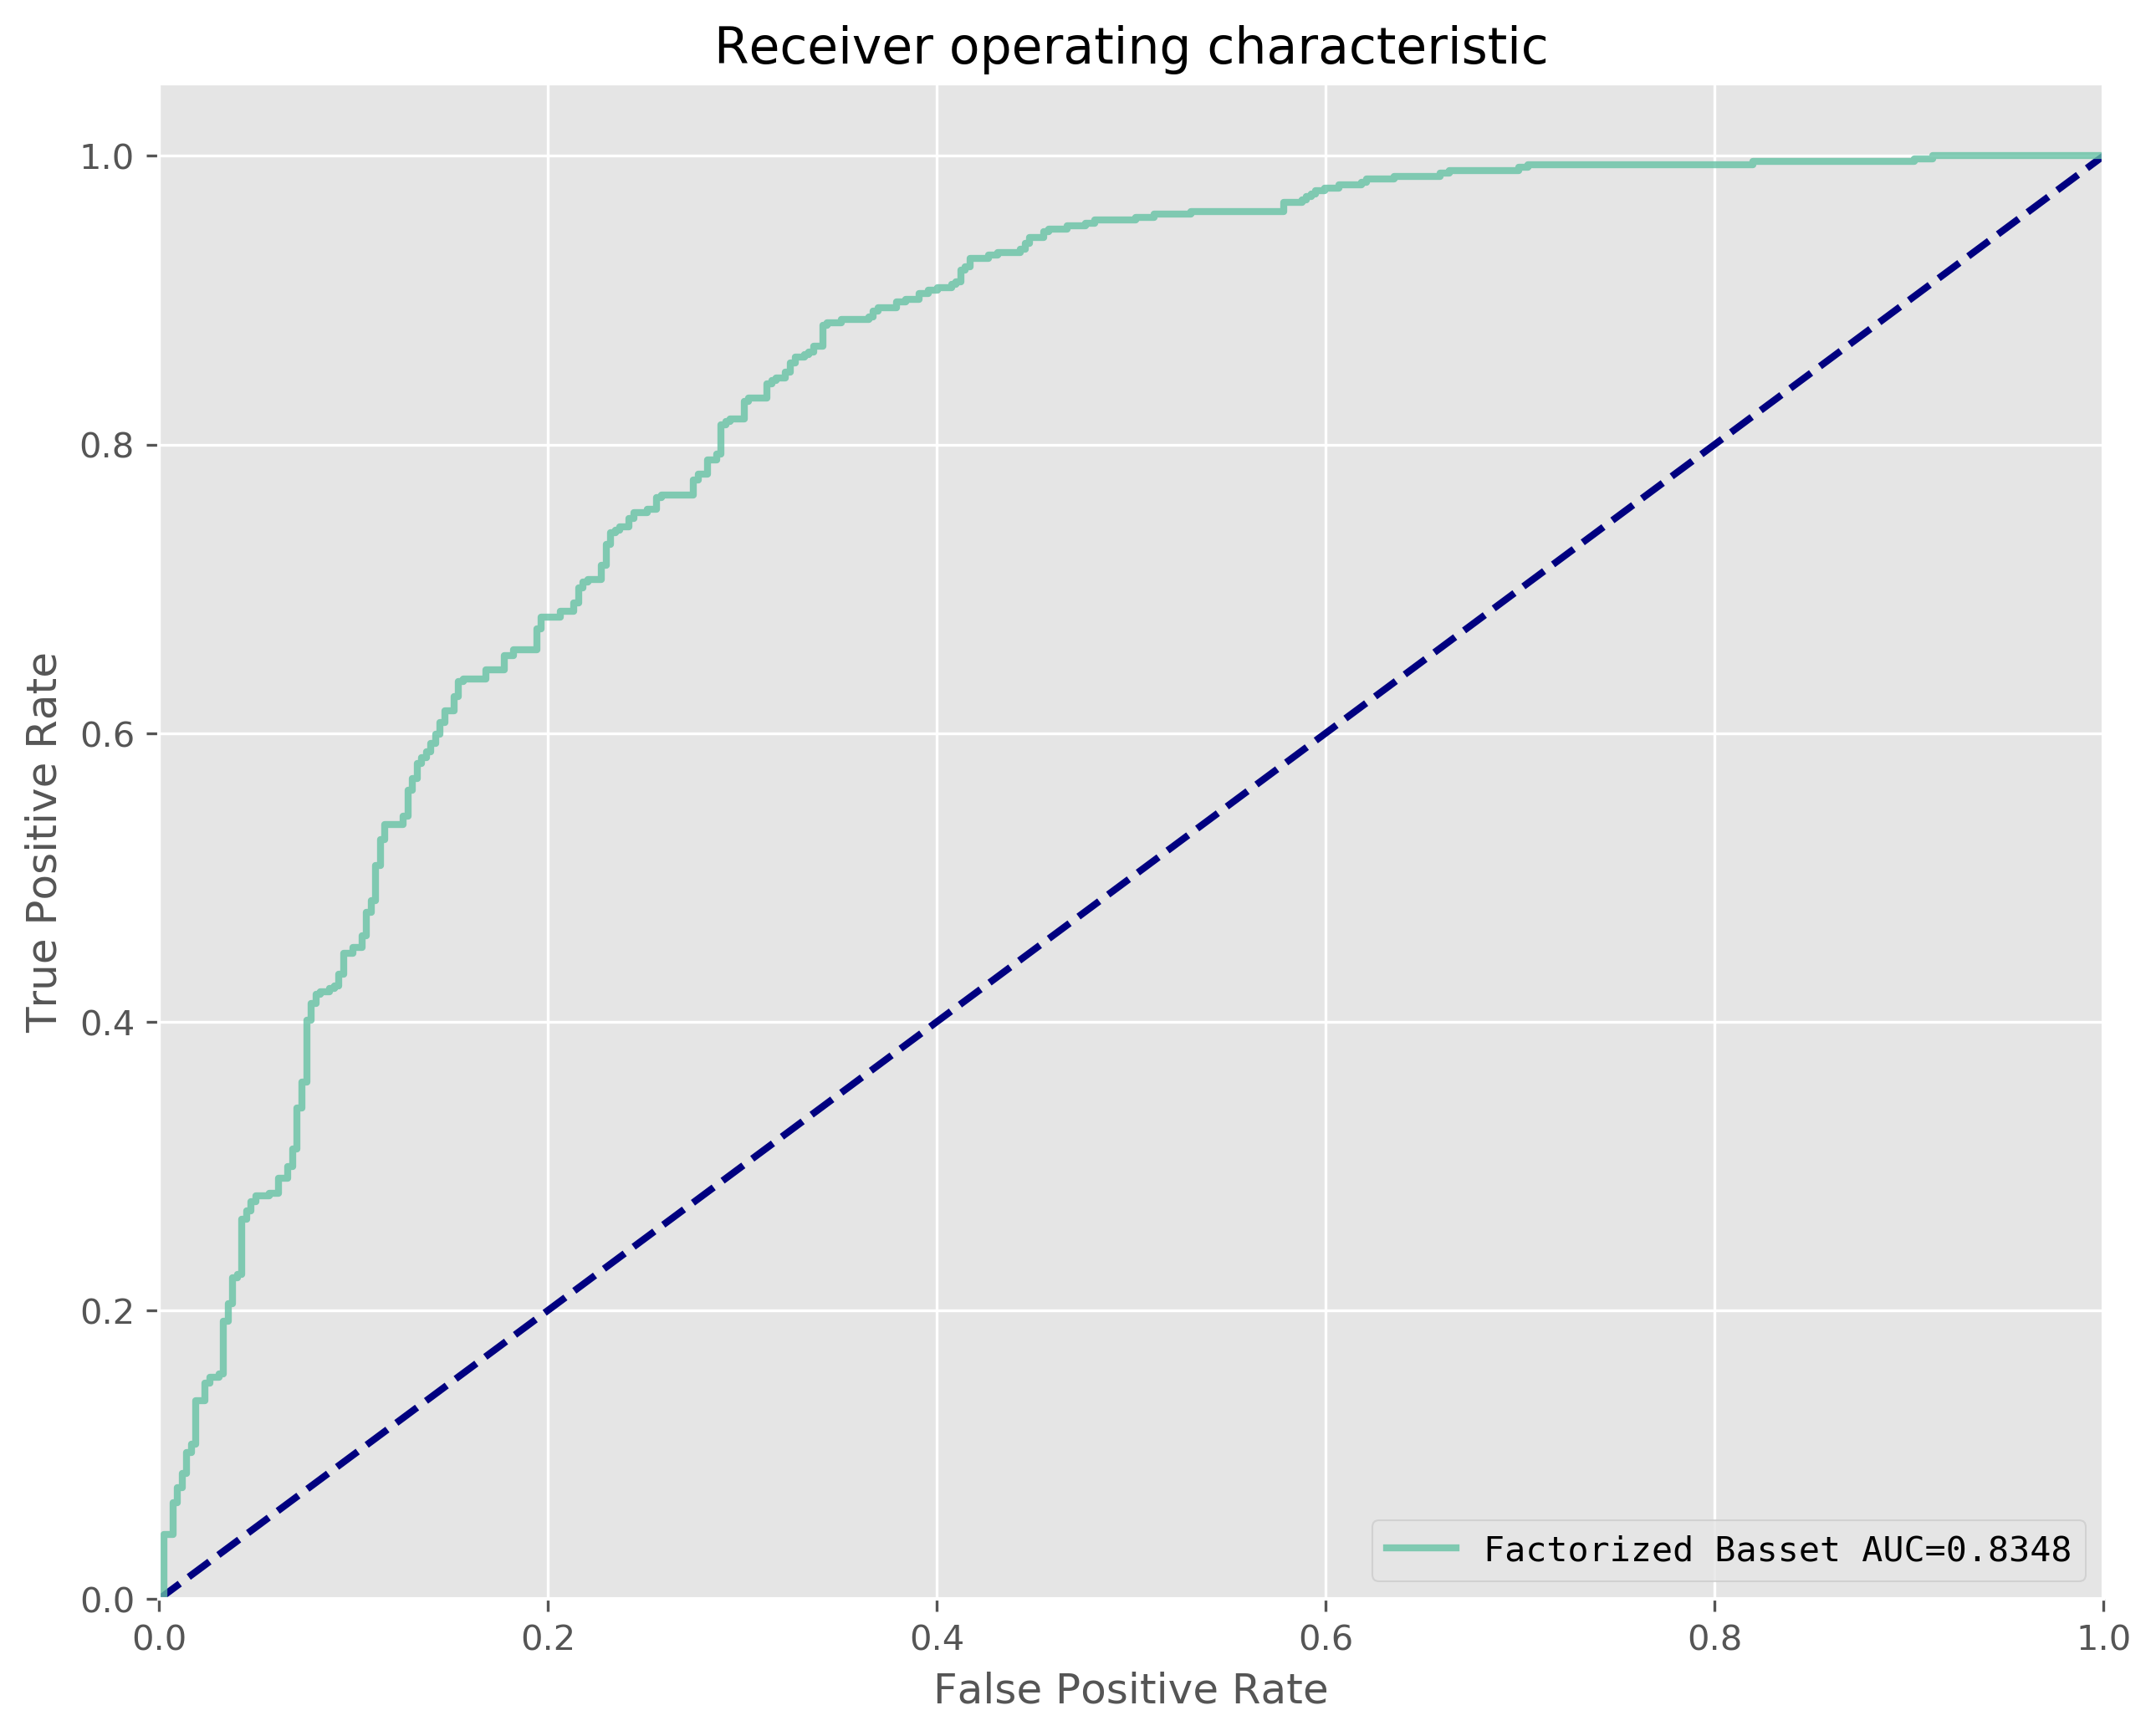

In [17]:
# Select by best validation AUROC
f_basset_best_index = np.argmax([perf.auroc for perf in f_basset_perf])
print(f_basset_best_index)
f_basset_model.load_state_dict(f_basset_state_dicts[f_basset_best_index])
f_basset_model.eval()
# print(f_basset_perf[f_basset_best_index])
importlib.reload(plotting_utils)
plotting_utils.plot_auroc({"Factorized Basset": f_basset_perf[f_basset_best_index]})
with open("factorized_basset.valid.perf", 'wb') as sink:
    pickle.dump(f_basset_perf[f_basset_best_index], sink)

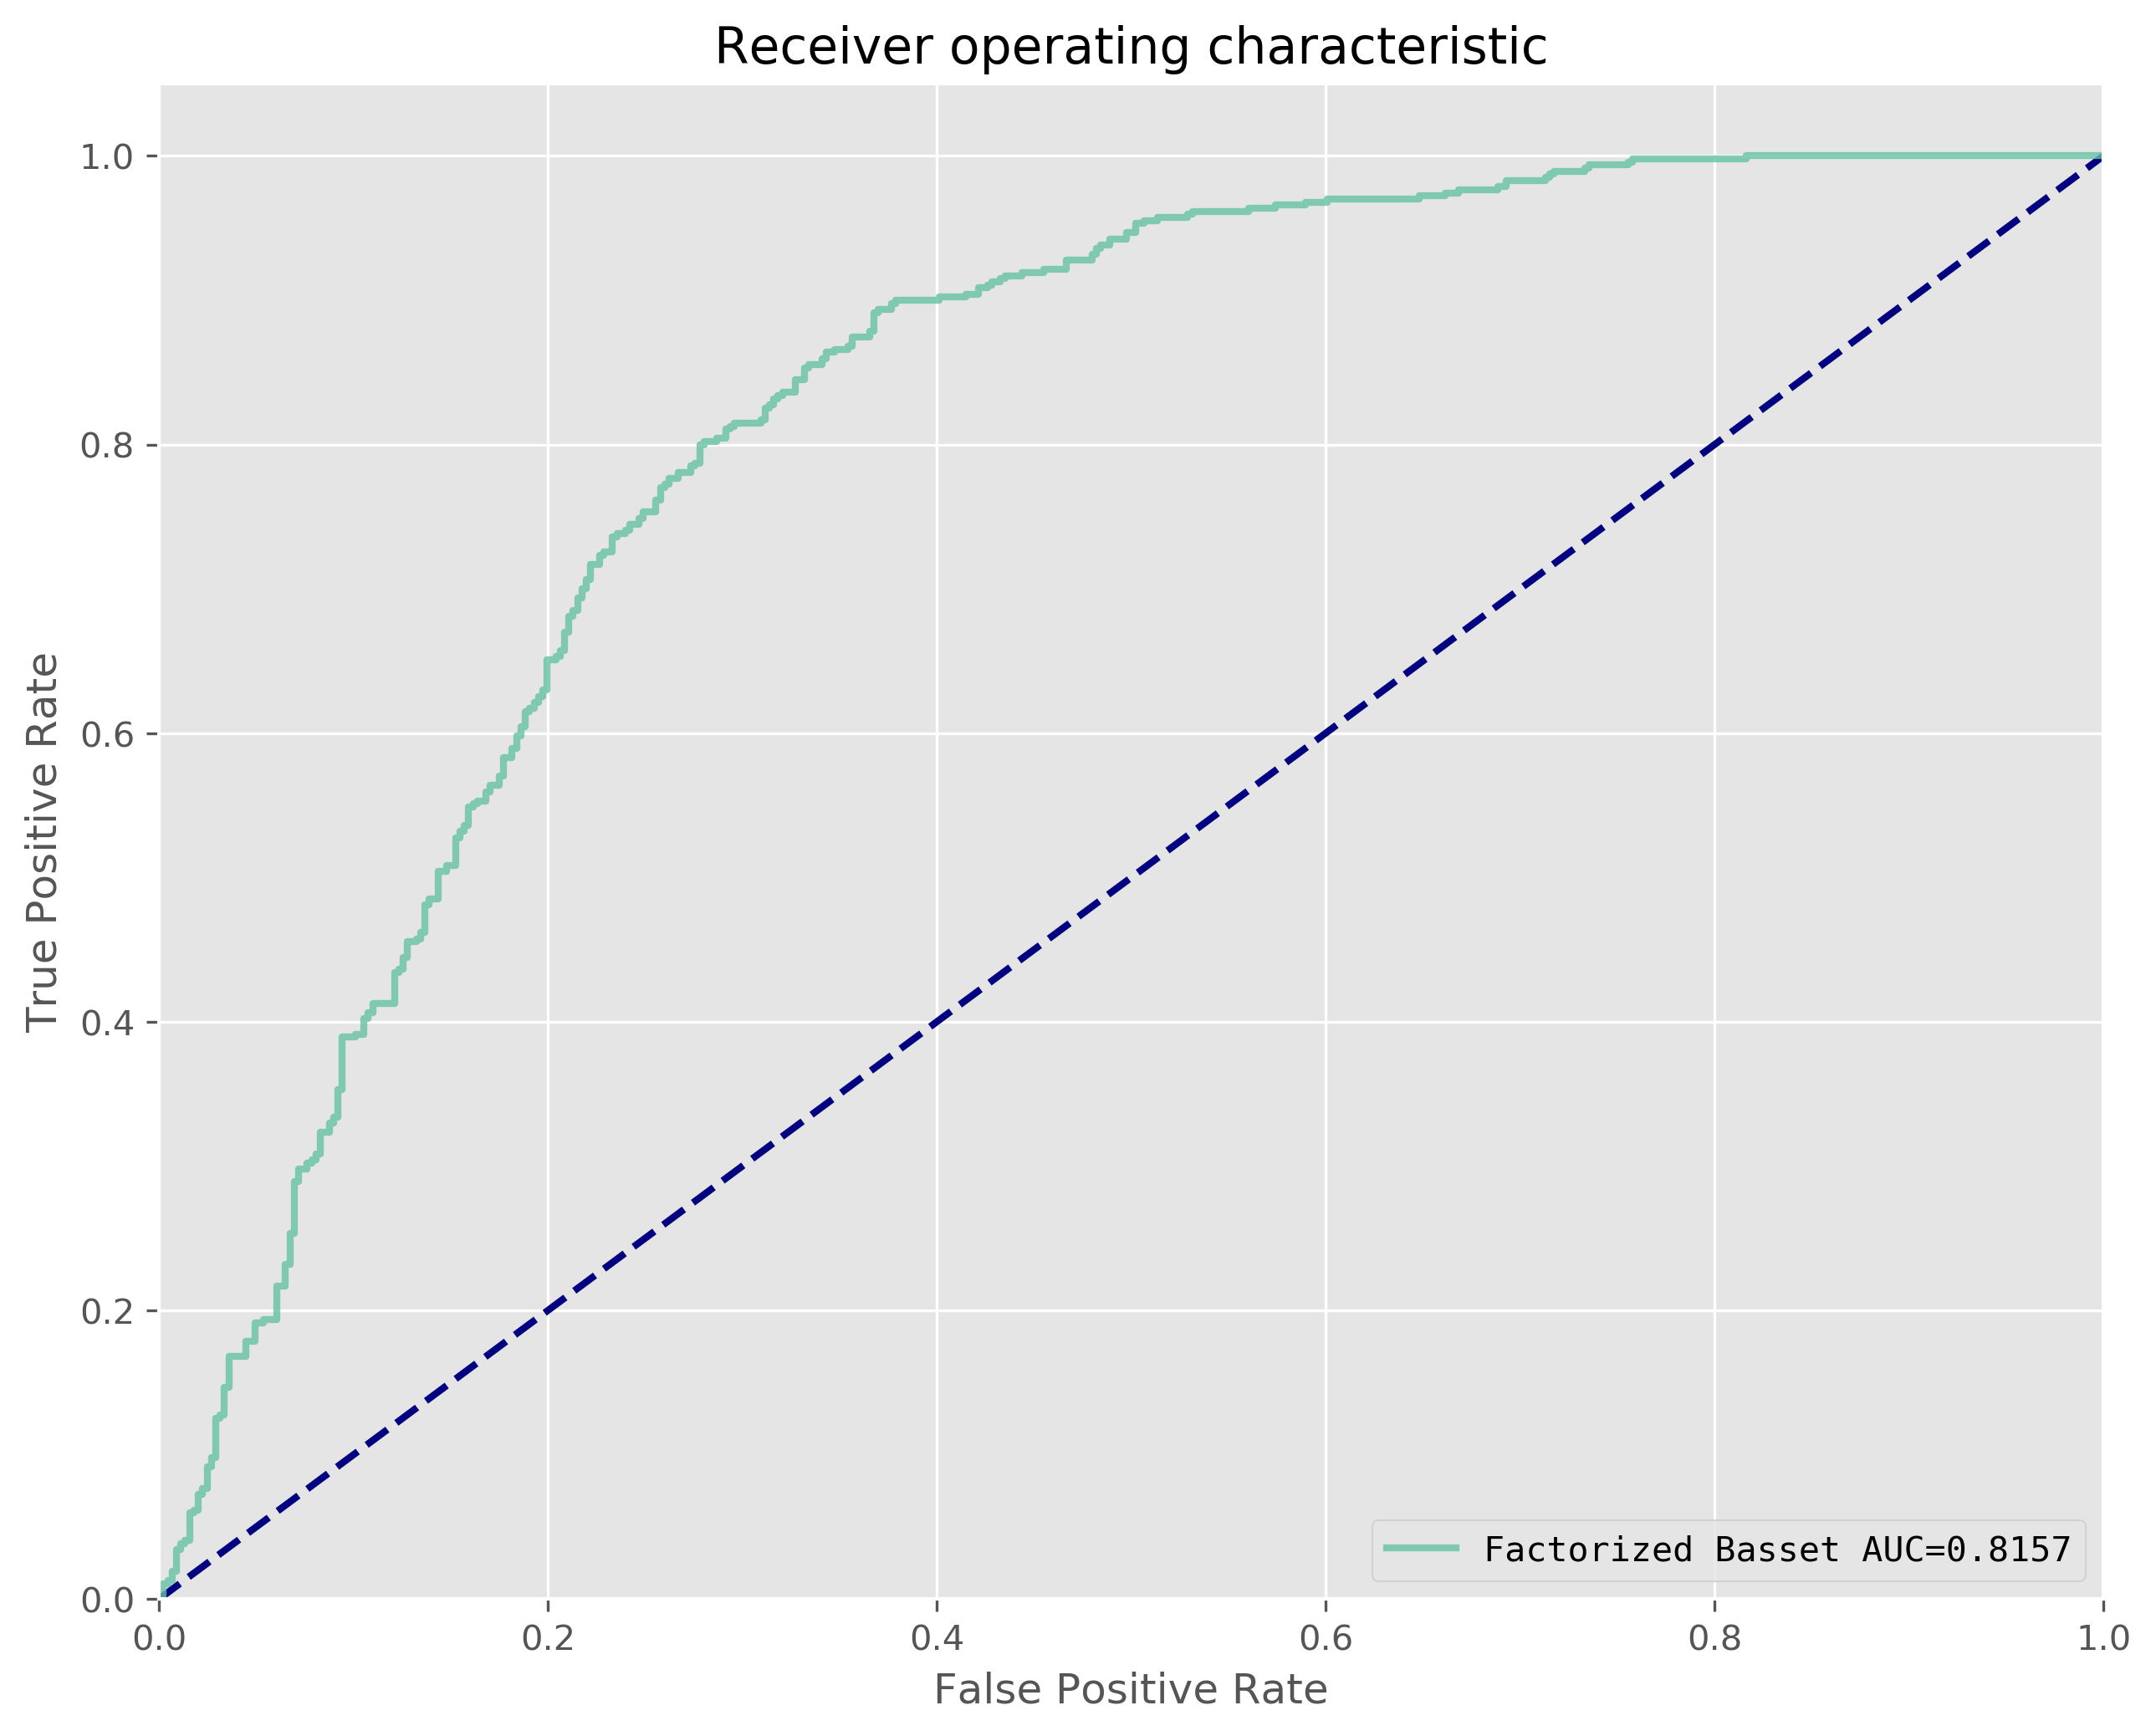

In [18]:
# Test set
f_basset_perf_test = pytorch_eval(f_basset_model, test_data)
plotting_utils.plot_auroc({"Factorized Basset": f_basset_perf_test})
with open("factorized_basset.test.perf", 'wb') as sink:
    pickle.dump(f_basset_perf_test, sink)

In [20]:
class Basset(nn.Module):
    """
    This model is also known to do well in transcription factor binding.
    This model is "shallower" than factorized basset, but has larger convolutions
    that may be able to pick up longer motifs
    """
    def __init__(self, dropout, num_classes):
        super(Basset, self).__init__()
        torch.manual_seed(3278)
        self.dropout = dropout

        self.conv1 = nn.Conv2d(4, 300, (19, 1), stride = (1, 1), padding=(9,0))
        self.conv2 = nn.Conv2d(300, 200, (11, 1), stride = (1, 1), padding = (5,0))
        self.conv3 = nn.Conv2d(200, 200, (7, 1), stride = (1, 1), padding = (4,0))

        self.bn1 = nn.BatchNorm2d(300)
        self.bn2 = nn.BatchNorm2d(200)
        self.bn3 = nn.BatchNorm2d(200)
        self.maxpool1 = nn.MaxPool2d((3, 1))
        self.maxpool2 = nn.MaxPool2d((4, 1))
        self.maxpool3 = nn.MaxPool2d((4, 1))

        self.fc1 = nn.Linear(4200, 1000)
        self.bn4 = nn.BatchNorm1d(1000)

        self.fc2 = nn.Linear(1000, 1000)
        self.bn5 = nn.BatchNorm1d(1000)

        self.fc3 = nn.Linear(1000, 1)

    def forward(self, s):
        s = s.permute(0, 2, 1).contiguous()                          # batch_size x 4 x 1000
        s = s.view(-1, 4, 1000, 1)                                   # batch_size x 4 x 1000 x 1 [4 channels]
        s = self.maxpool1(F.relu(self.bn1(self.conv1(s))))           # batch_size x 300 x 333 x 1
        s = self.maxpool2(F.relu(self.bn2(self.conv2(s))))           # batch_size x 200 x 83 x 1
        s = self.maxpool3(F.relu(self.bn3(self.conv3(s))))           # batch_size x 200 x 21 x 1
        s = s.view(-1, 4200)
        
        s = F.dropout(F.relu(self.bn4(self.fc1(s))), p=self.dropout, training=self.training)  # batch_size x 1000
        s = F.dropout(F.relu(self.bn5(self.fc2(s))), p=self.dropout, training=self.training)  # batch_size x 1000
        intermediate_out = s
        
        s = self.fc3(s)
        s = torch.sigmoid(s)

        return s, intermediate_out

basset_model = Basset(0.1, 2)
basset_perf, basset_state_dicts = pytorch_train(
    basset_model,
    train_data,
    valid_data,
)

Epoch 0/30
Validation accuracy: 0.6473799126637555
Validation F1:       0.5593451568894953
Validation AUPRC:    0.801039168855661
Validation AUROC:    0.8250954582957575
Validation CE loss:  0.6444012295082052
Runtime for epoch: 9.81587553024292
Epoch 1/30
Validation accuracy: 0.6299126637554585
Validation F1:       0.7414187643020596
Validation AUPRC:    0.7758068383277377
Validation AUROC:    0.7734088685073969
Validation CE loss:  0.6819013485639371
Runtime for epoch: 11.663089990615845
Epoch 2/30
Validation accuracy: 0.4868995633187773
Validation F1:       0.10305343511450382
Validation AUPRC:    0.7797850282875278
Validation AUROC:    0.7670481800564115
Validation CE loss:  1.2254807490522122
Runtime for epoch: 9.833756923675537
Epoch 3/30
Validation accuracy: 0.6539301310043668
Validation F1:       0.7457898957497995
Validation AUPRC:    0.7565585687978611
Validation AUROC:    0.7446130821037281
Validation CE loss:  0.7426152917699632
Runtime for epoch: 8.81308102607727
Epoch 4/3

In [21]:
dropouts = [0.1, 0.25, 0.5]
learning_rates = [0.001, 0.005, 0.01]
l2_regs = [0, 0.1, 0.5, 1.0]
batch_sizes = [16, 32, 64]

basset_arg_combos = list(itertools.product(dropouts, learning_rates, l2_regs, batch_sizes))
basset_hyperparam_perfs = []
for combo in tqdm.tqdm_notebook(basset_arg_combos):
    dropout_rate, lr, l2_lambda, bs = combo
    data_loader_params = {
        "batch_size": bs,
        "shuffle": True,
        "num_workers": 6,
    }
    basset_model = Basset(dropout_rate, 2)
    basset_perf, basset_state_dicts = pytorch_train(
        basset_model,
        train_data,
        valid_data,
        optim=lambda x: torch.optim.Adam(x, lr=lr, weight_decay=l2_lambda),
        verbose=False,
        max_epochs=30,
        data_loader_params=data_loader_params,
    )

    basset_hyperparam_perfs.append(f_basset_perf)

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average

In [22]:
basset_aurocs = [max([p.auroc for p in epoch_perf_list]) for epoch_perf_list in basset_hyperparam_perfs]
basset_auprcs = [max([p.auprc for p in epoch_perf_list]) for epoch_perf_list in basset_hyperparam_perfs]
basset_accs = [max([p.accuracy for p in epoch_perf_list]) for epoch_perf_list in basset_hyperparam_perfs]

In [23]:
np.argmax(basset_aurocs), np.max(basset_aurocs)

(0, 0.8347516165550587)

In [26]:
np.argmax(basset_auprcs), np.max(basset_auprcs)

(0, 0.8223956293915374)

In [24]:
basset_best_params = basset_arg_combos[np.argmax(basset_aurocs)]
basset_best_params

(0.1, 0.001, 0, 16)

In [25]:
basset_dropout, basset_lr, basset_l2, basset_bs = (0.1, 0.001, 0, 16)

In [27]:
basset_model = Basset(basset_dropout, 2)
basset_perf, basset_state_dicts = pytorch_train(
    basset_model,
    train_data,
    valid_data,
    optim=lambda x: torch.optim.Adam(x, lr=basset_lr, weight_decay=basset_l2),
    data_loader_params={"batch_size": basset_bs, "shuffle": True, "num_workers": 6}
)

Epoch 0/30
Validation accuracy: 0.6975982532751092
Validation F1:       0.7738775510204081
Validation AUPRC:    0.780539642410134
Validation AUROC:    0.7988804037070437
Validation CE loss:  0.5937844826491507
Runtime for epoch: 25.03811025619507
Epoch 1/30
Validation accuracy: 0.6495633187772926
Validation F1:       0.7121076233183857
Validation AUPRC:    0.7164426545843703
Validation AUROC:    0.697042231901299
Validation CE loss:  0.6429457882972341
Runtime for epoch: 28.08777666091919
Epoch 2/30
Validation accuracy: 0.7510917030567685
Validation F1:       0.7625000000000001
Validation AUPRC:    0.8118118990405081
Validation AUROC:    0.828002379262045
Validation CE loss:  0.5221116600416682
Runtime for epoch: 20.084296941757202
Epoch 3/30
Validation accuracy: 0.6550218340611353
Validation F1:       0.6351039260969977
Validation AUPRC:    0.740912525821053
Validation AUROC:    0.7611048218431605
Validation CE loss:  0.6470835104858769
Runtime for epoch: 23.413837909698486
Epoch 4/30

2


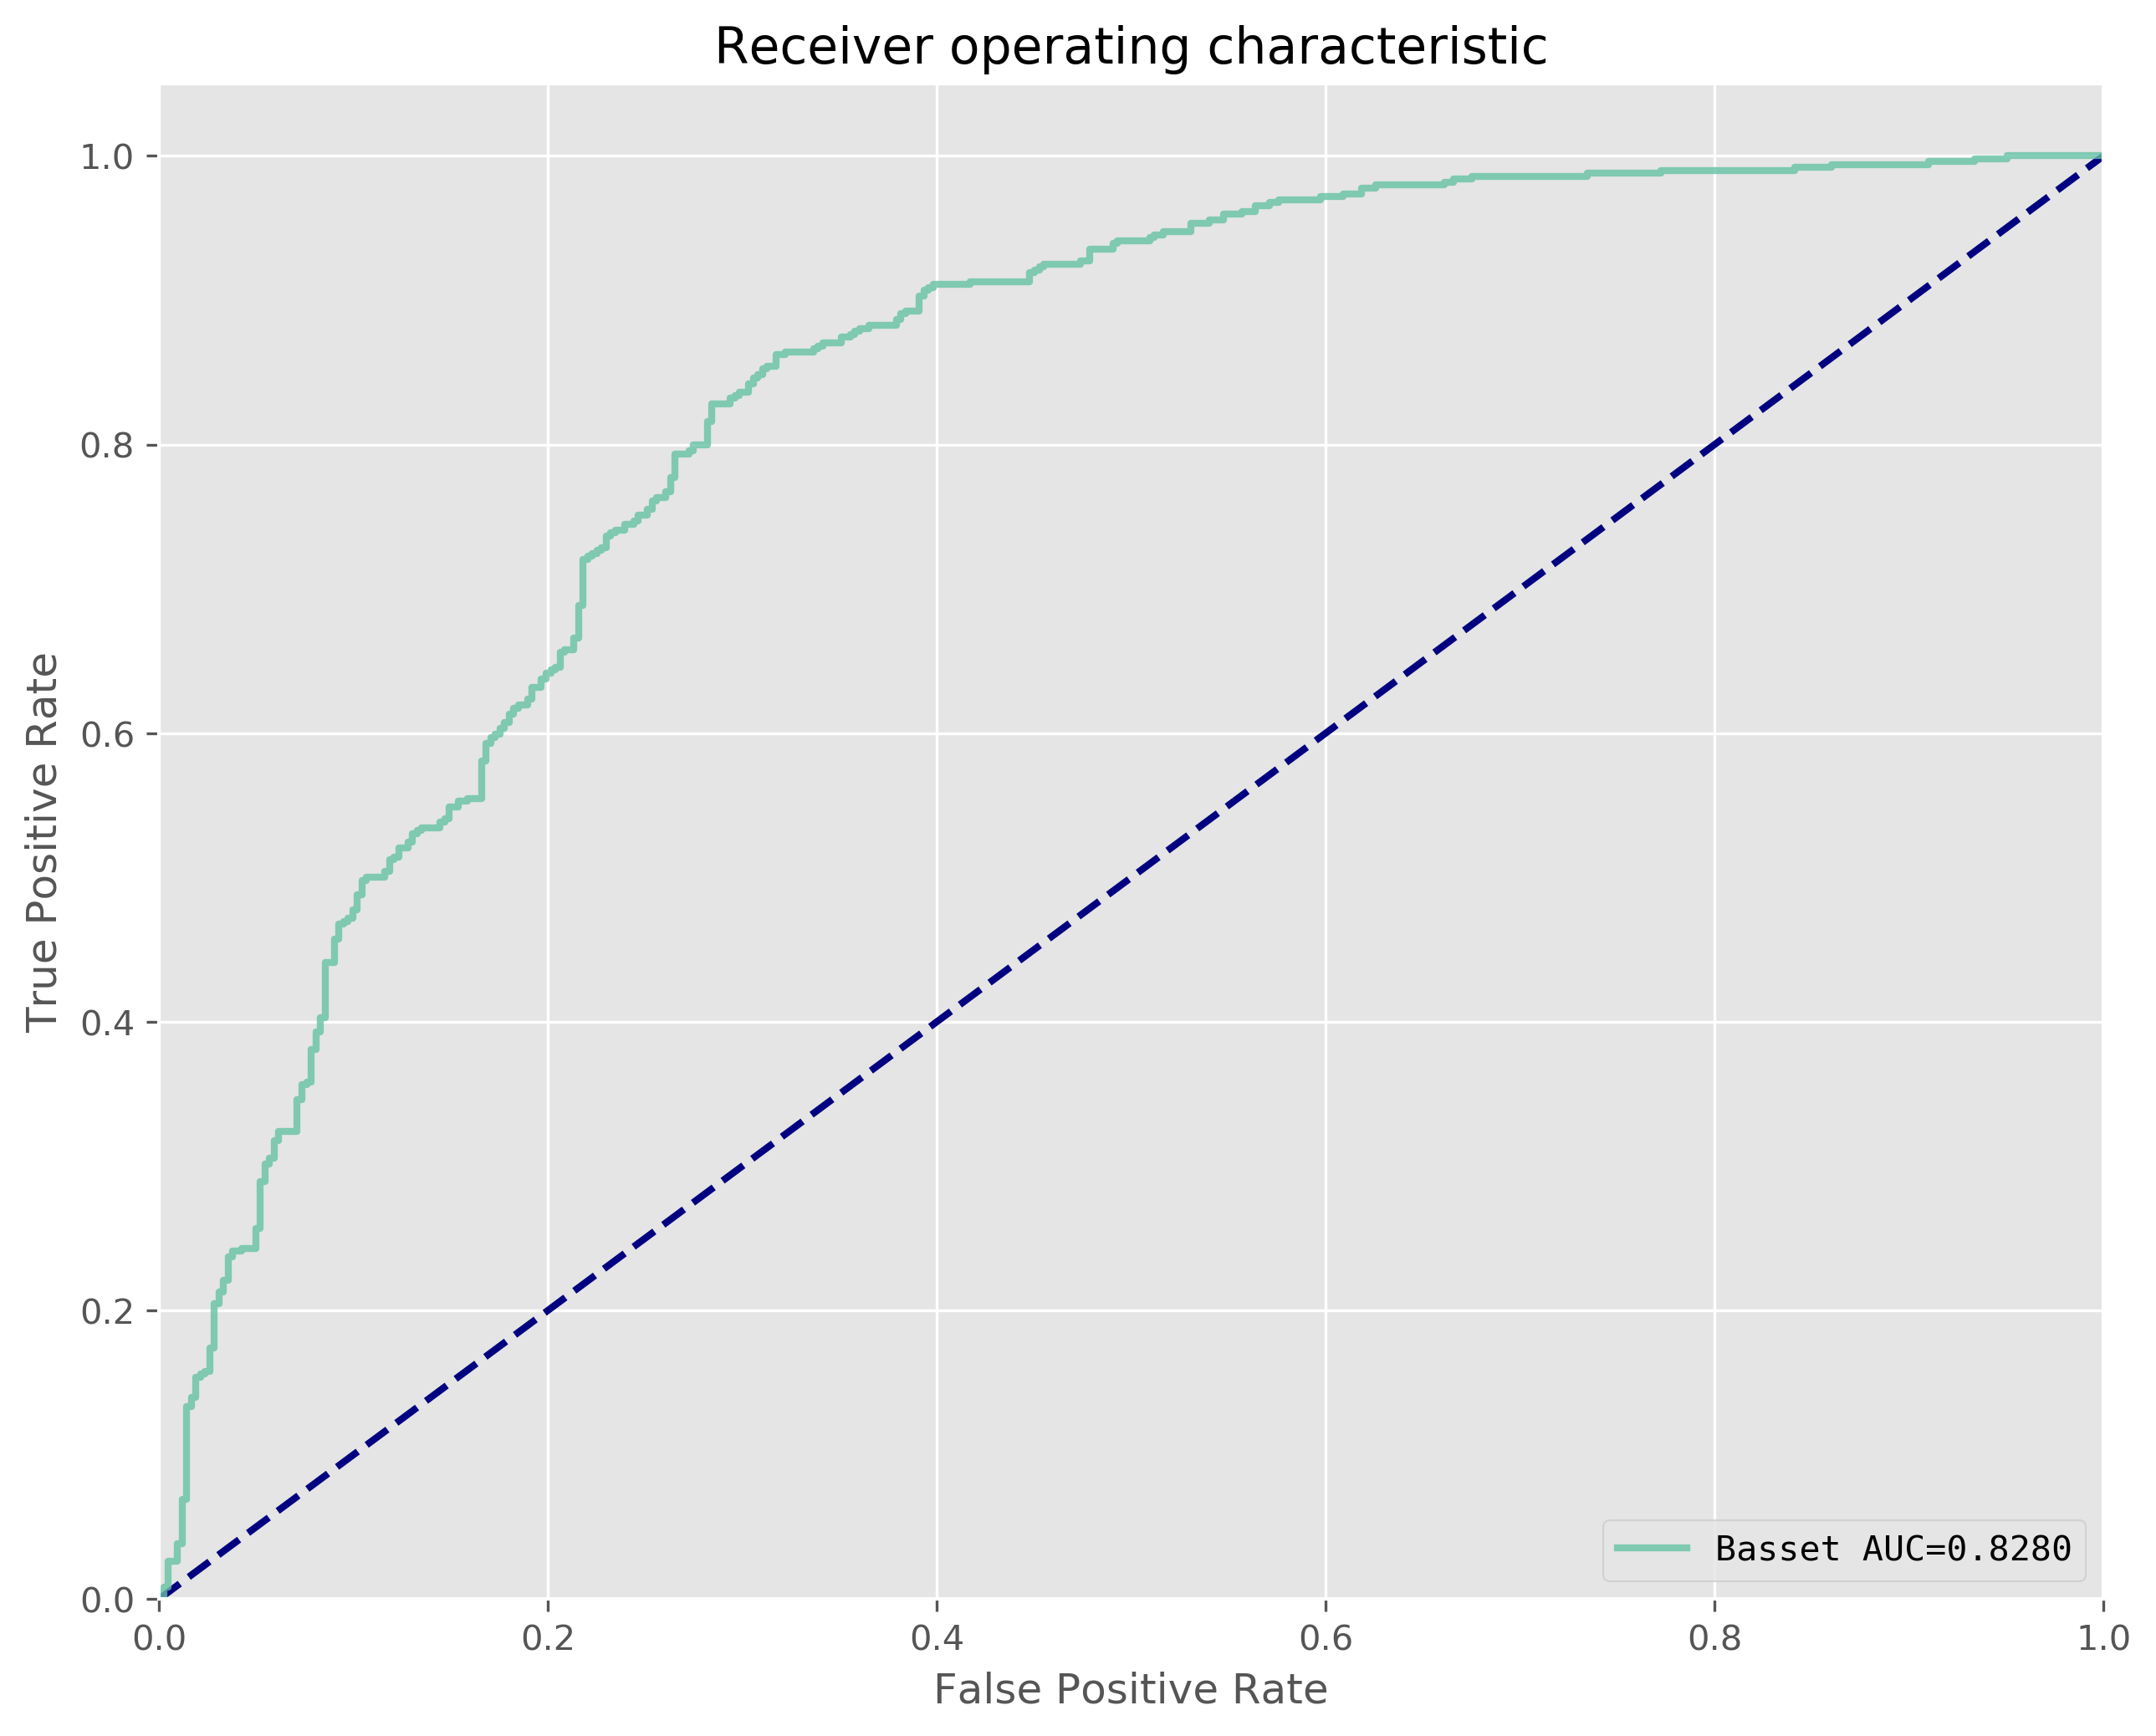

In [28]:
# Select by best validation AUROC
basset_best_index = np.argmax([perf.auroc for perf in basset_perf])
print(basset_best_index)
basset_model.load_state_dict(basset_state_dicts[basset_best_index])
basset_model.eval()
plotting_utils.plot_auroc({"Basset": basset_perf[basset_best_index]})
with open("vanilla_basset.valid.perf", 'wb') as sink:
    pickle.dump(basset_perf[basset_best_index], sink)

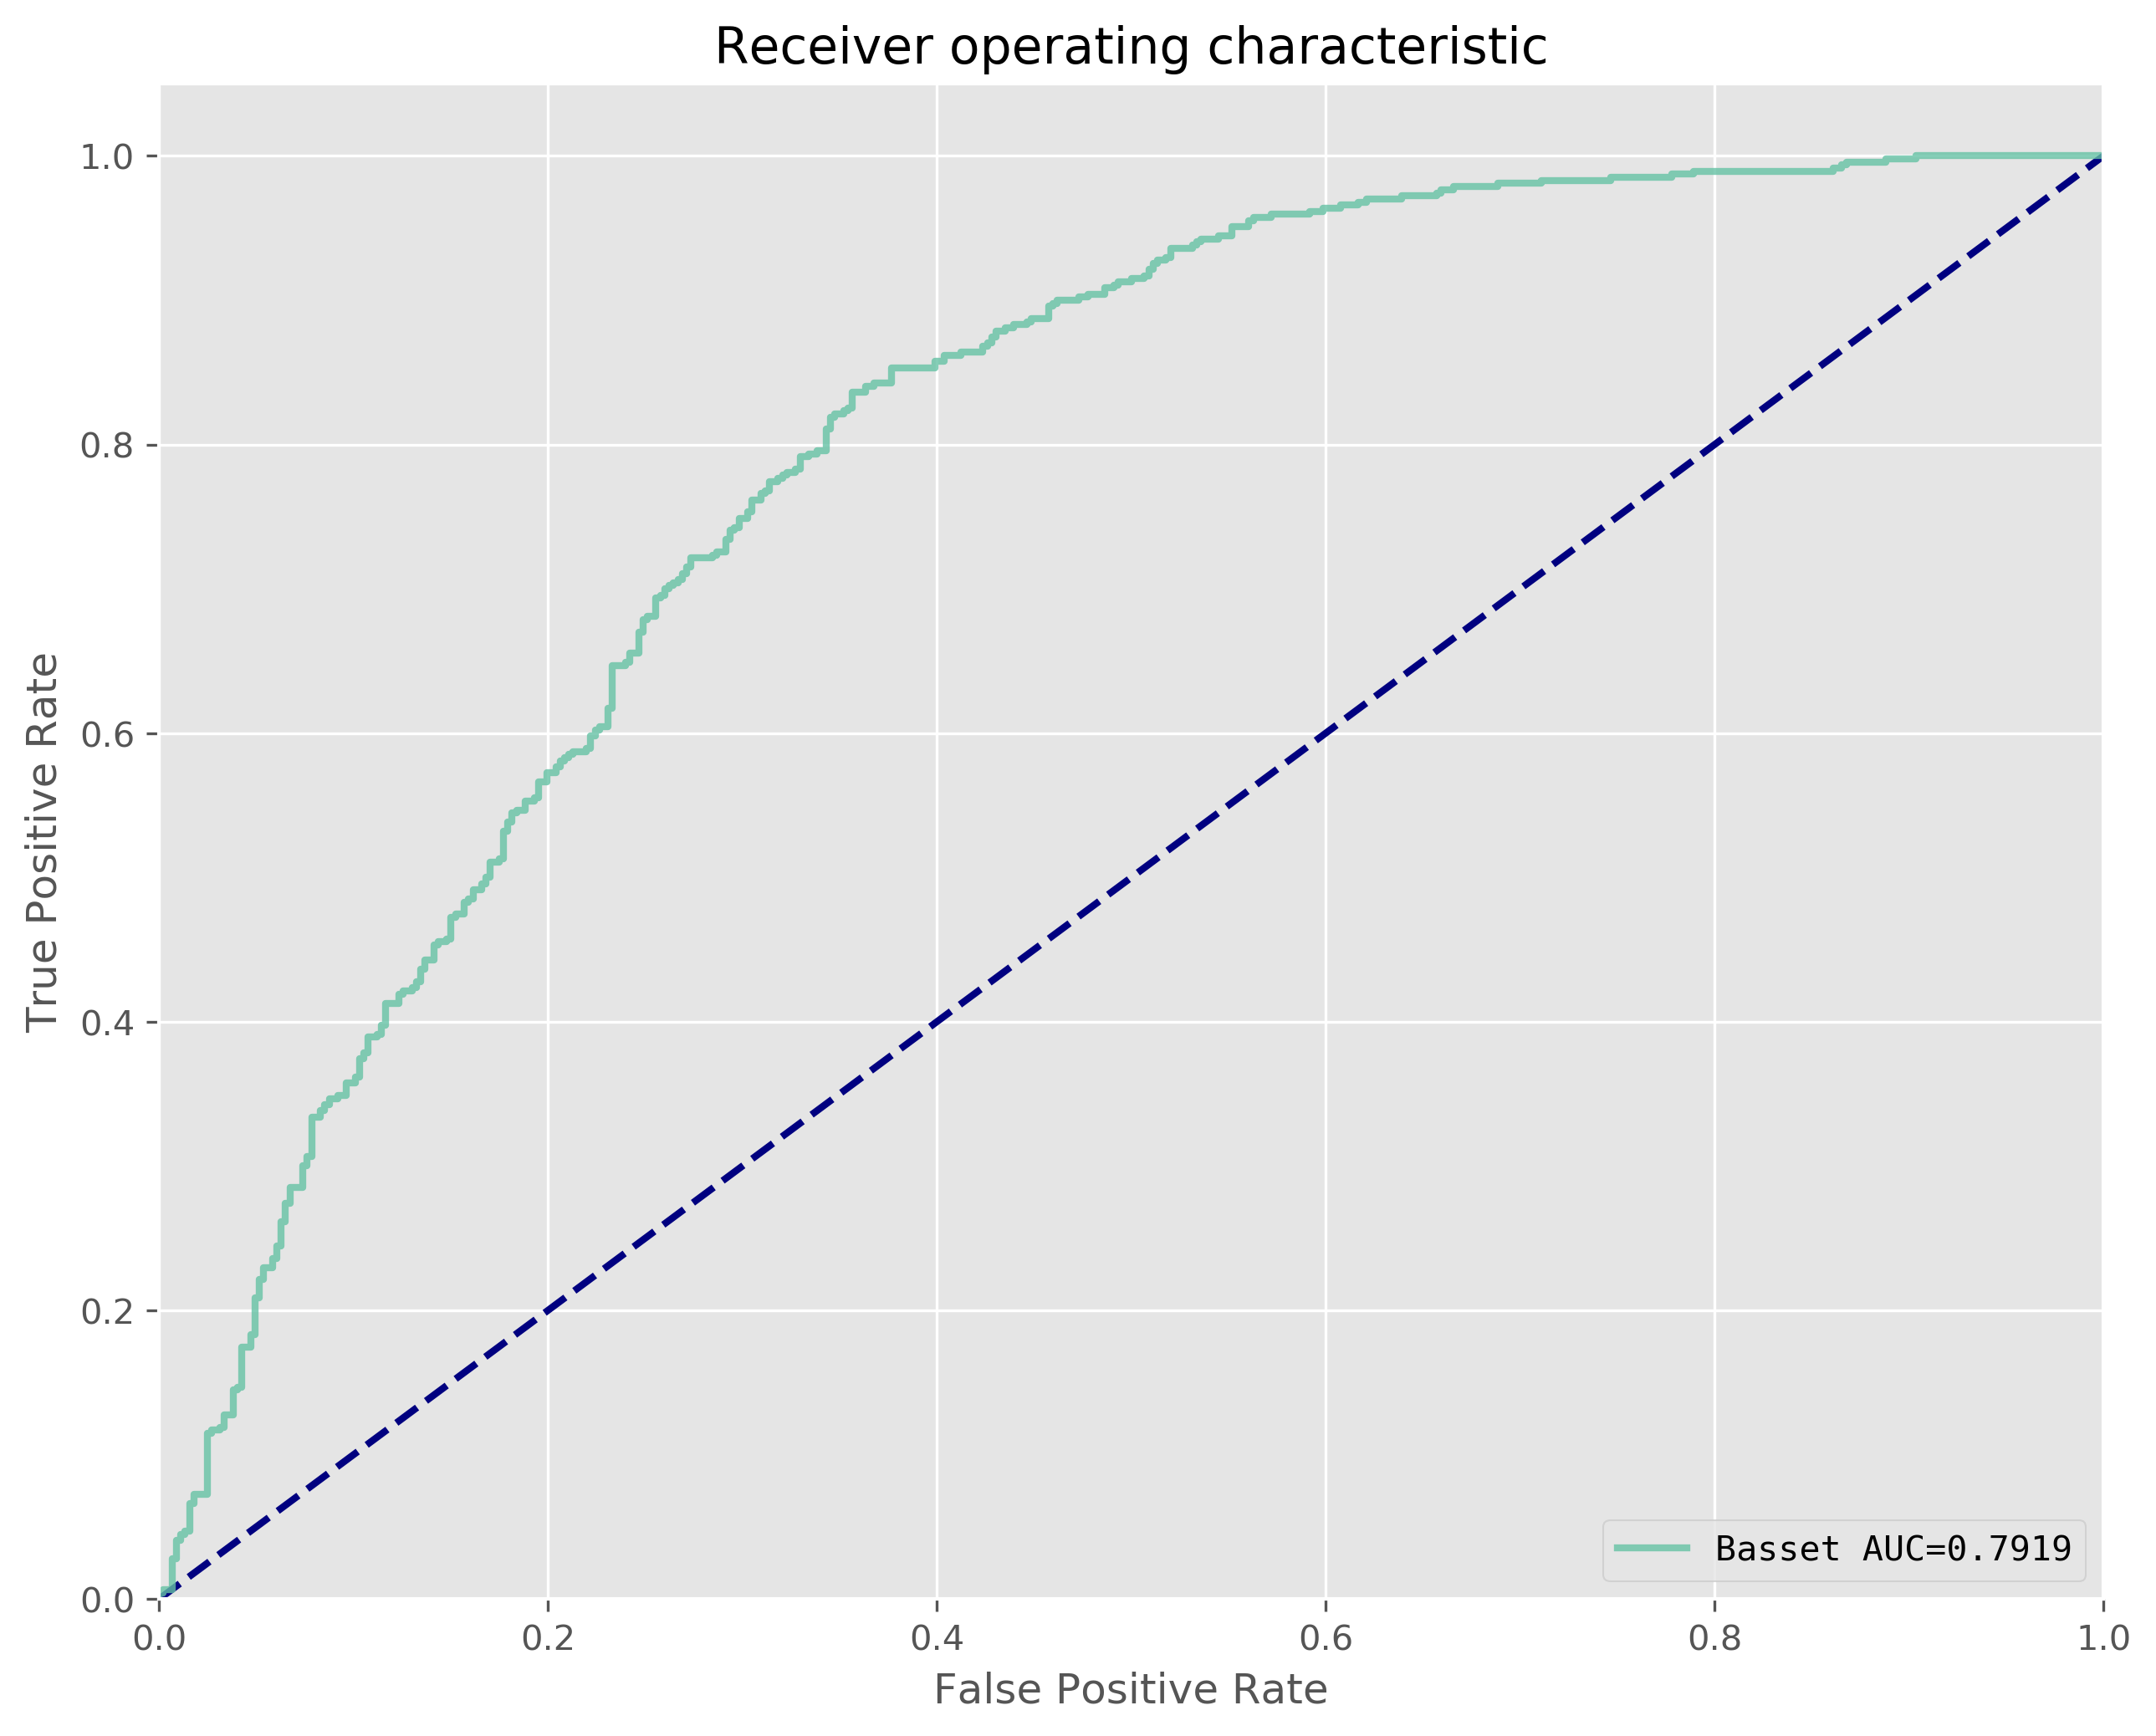

In [29]:
# Test set
basset_perf_test = pytorch_eval(basset_model, test_data)
plotting_utils.plot_auroc({"Basset": basset_perf_test})
with open("vanilla_basset.test.perf", 'wb') as sink:
    pickle.dump(basset_perf_test, sink)

## Networks based on k-mer featurization

In [3]:
importlib.reload(seq)
importlib.reload(data_loader)
importlib.reload(pwm)
kmer_train_data = data_loader.NLSvNESDataset('train', kmer_sizes=[2, 3, 4, 5], pwms=pwm.load_all_ppm_in_dir(log_transform=False))
kmer_valid_data = data_loader.NLSvNESDataset('valid', kmer_sizes=[2, 3, 4, 5], pwms=pwm.load_all_ppm_in_dir(log_transform=False))
kmer_test_data = data_loader.NLSvNESDataset('test', kmer_sizes=[2, 3, 4, 5], pwms=pwm.load_all_ppm_in_dir(log_transform=False))

# Some general metrics about the data
kmer_train_data[0][0].shape

INFO:root:Read in 193 PWMs
INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.0002731

torch.Size([1553])

In [4]:
print(kmer_train_data.pwm_matrix)

[[ 29  82  18 ...   6  16  72]
 [  5  24  16 ...   1   7  42]
 [  8  52  10 ...   1   5  39]
 ...
 [ 74  52  40 ...  22  40 124]
 [  2  14   3 ...   0   2  31]
 [  2  11   3 ...   2   2   8]]


In [5]:
class DenseNet(nn.Module):
    """
    Based on deepLncRNA paper, but without the manually engineered motif features
    https://github.com/bgudenas/DeepLncRNA
    Architecture consists of one input layer, three hidden layers using ReLU activation and a softmax output layer.
    Hidden layer dropout was used to randomly mask half of the connections in each layer during training of the DNN.
    Input dropout was also applied which randomly masks some of the hidden units in each layer to increase the generalizability of the model.
    Furthermore, regularization was applied using the L1 and L2 weight penalties to the cost function.
    
    Status of Neuron Layers: predicting Loc, 2-class classification, bernoulli distribution, CrossEntropy loss, 51,338 weights/biases, 846.2 KB, 628,046 training samples, mini-batch size 1
    Pulled from their saved model (via R h2o package)
      layer units             type dropout       l1       l2 mean_rate rate_rms momentum mean_weight
    1     1  1582            Input 40.00 %       NA       NA        NA       NA       NA          NA
    2     2    32 RectifierDropout 50.00 % 0.000010 0.000100  0.005490 0.004741 0.000000    0.000883
    3     3    16 RectifierDropout 50.00 % 0.000010 0.000100  0.000998 0.000581 0.000000   -0.050156
    4     4     8 RectifierDropout 50.00 % 0.000010 0.000100  0.000945 0.000778 0.000000   -0.141213
    5     5     2          Softmax      NA 0.000010 0.000100  0.001736 0.000549 0.000000    0.566711
    """
    def __init__(self, input_len=1553, seed=3278):
        super(DenseNet, self).__init__()
        torch.manual_seed(seed)
        
        self.input_drop = nn.Dropout(0.4)
        self.fc1 = nn.Linear(input_len, 32)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 16)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(16, 8)
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(self.input_drop(x)))
        x = F.relu(self.fc2(self.drop1(x)))
        x = F.relu(self.fc3(self.drop2(x)))
        x = F.softmax(self.fc4(self.drop3(x)), dim=1)
        x = torch.narrow(x, 1, 1, 1)  # Keep only the output for positive class
        return x, None

In [6]:
dense_model = DenseNet(kmer_train_data[0][0].shape[-1])
dense_model_perf, dense_model_state_dicts = pytorch_train(
    dense_model,
    kmer_train_data,
    kmer_valid_data,
    optim=lambda x: torch.optim.SGD(x, lr=0.001, weight_decay=0.1),  # L2 reg 1e-3
#     l1_reg=0.1,
)

Epoch 0/30
Validation accuracy: 0.4596069868995633
Validation F1:       0.0
Validation AUPRC:    0.6760258482798815
Validation AUROC:    0.6992248210756566
Validation CE loss:  0.7131164774630107
Runtime for epoch: 7.689034700393677
Epoch 1/30
Validation accuracy: 0.4606986899563319
Validation F1:       0.0
Validation AUPRC:    0.6447061131495064
Validation AUROC:    0.6838939309630254
Validation CE loss:  0.7068404910020887
Runtime for epoch: 7.478724002838135
Epoch 2/30
Validation accuracy: 0.4606986899563319
Validation F1:       0.0
Validation AUPRC:    0.6276863521511561
Validation AUROC:    0.6651692346067501
Validation CE loss:  0.7015698994813914
Runtime for epoch: 7.7951109409332275
Epoch 3/30
Validation accuracy: 0.4606986899563319
Validation F1:       0.0
Validation AUPRC:    0.6146928150621722
Validation AUROC:    0.6674069881228772
Validation CE loss:  0.6984825379727081
Runtime for epoch: 7.537838935852051
Epoch 4/30
Validation accuracy: 0.4606986899563319
Validation F1:  

29


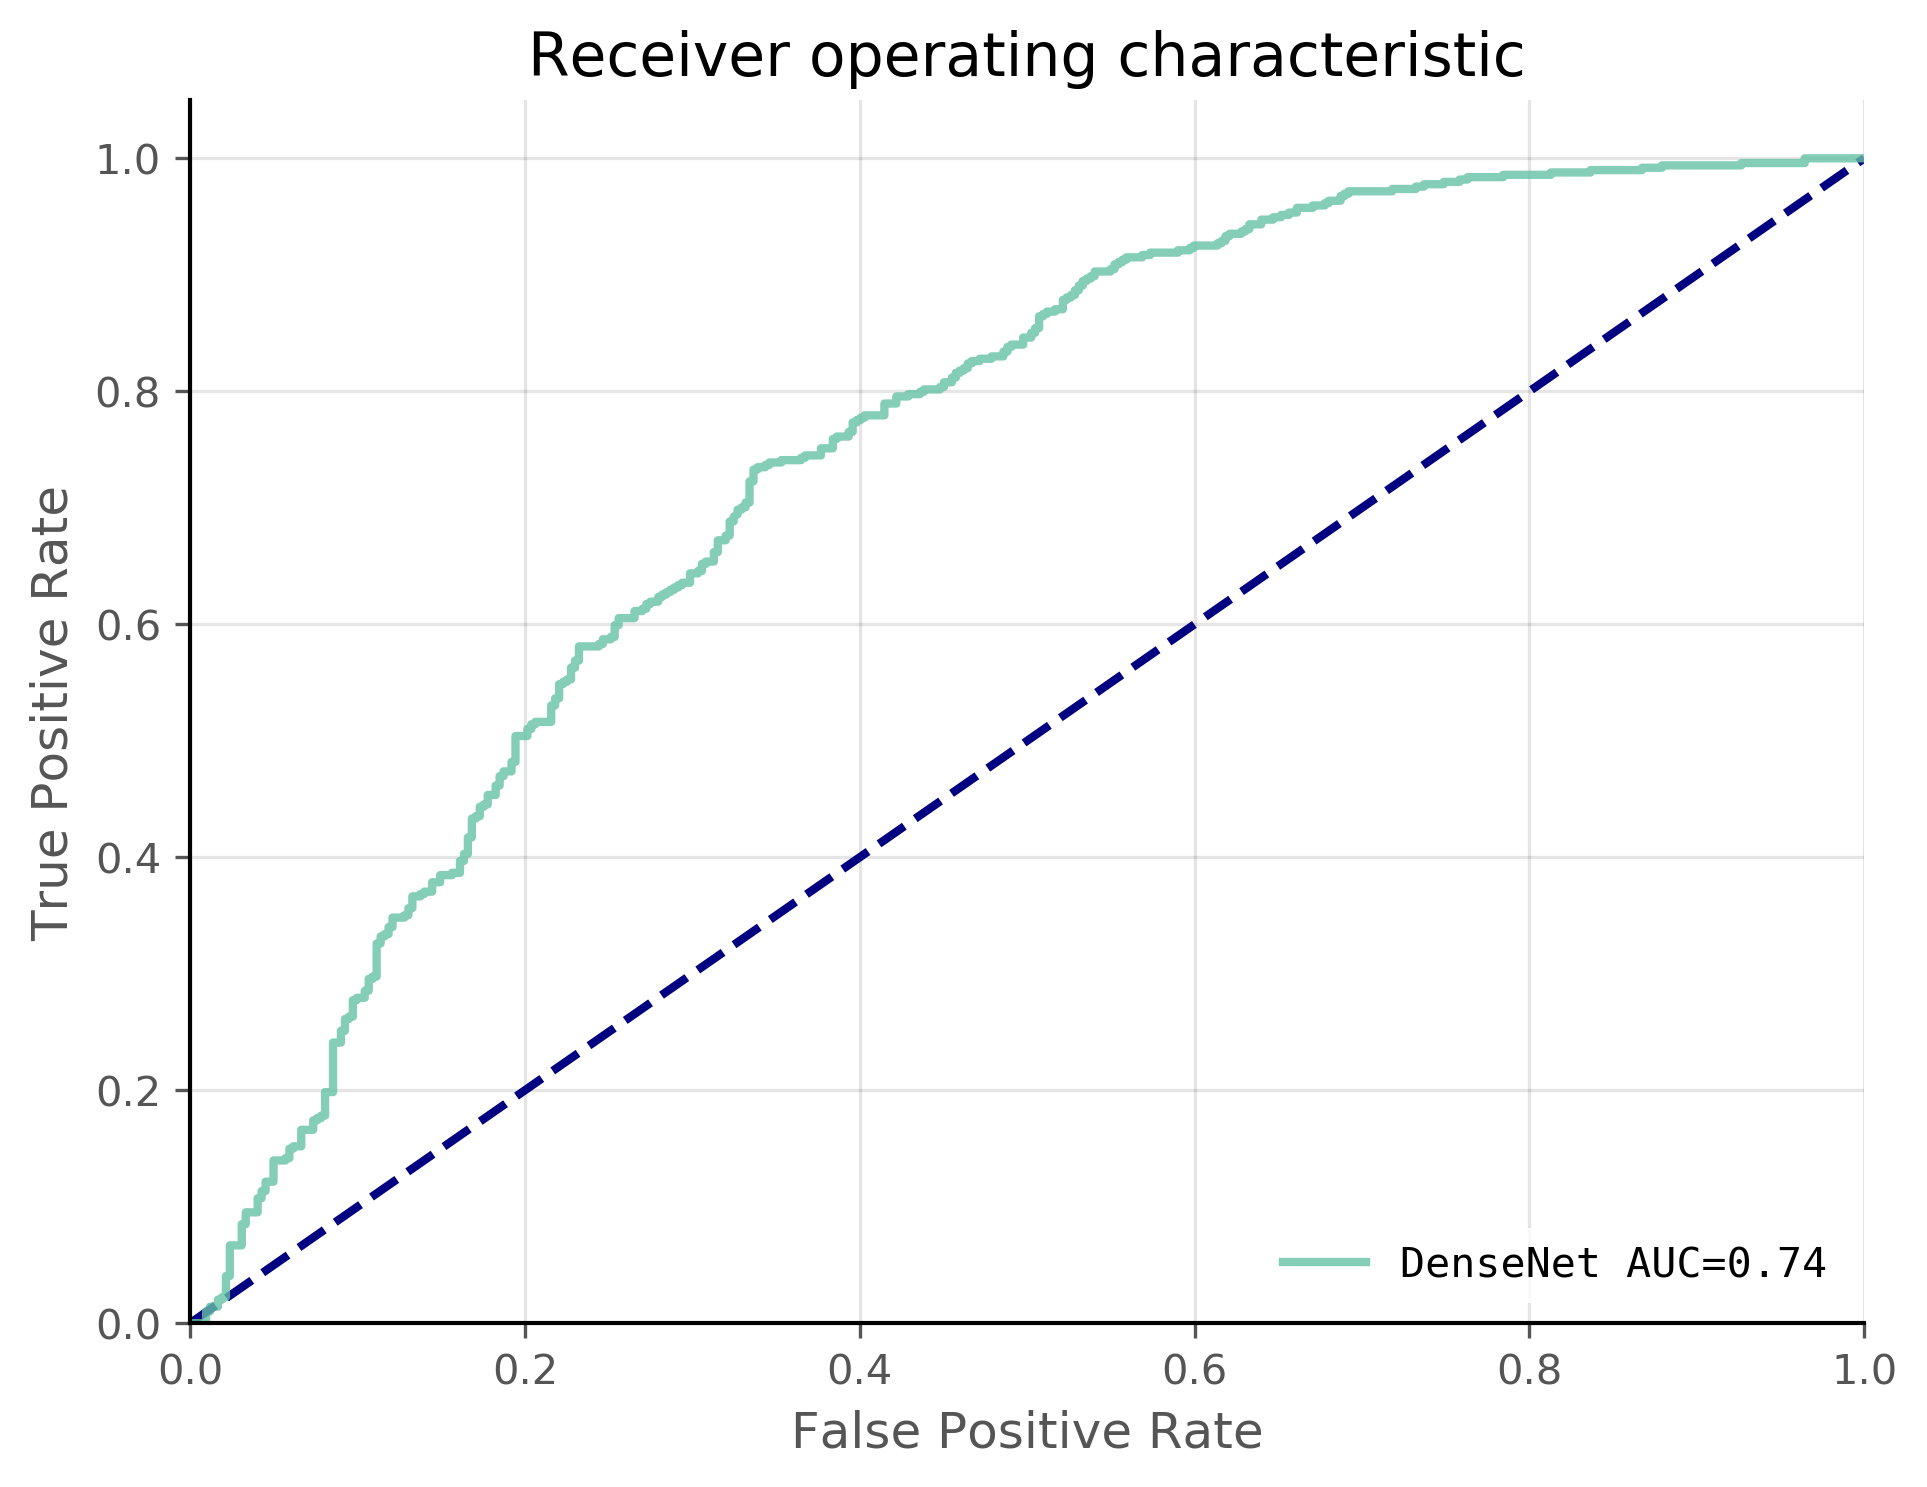

In [7]:
# Select by best validation AUROC
dense_best_index = np.argmax([perf.auroc for perf in dense_model_perf])
print(dense_best_index)
plotting_utils.plot_auroc({"DenseNet": dense_model_perf[dense_best_index]})
with open("densenet.perf", 'wb') as sink:
    pickle.dump(dense_model_perf[dense_best_index], sink)

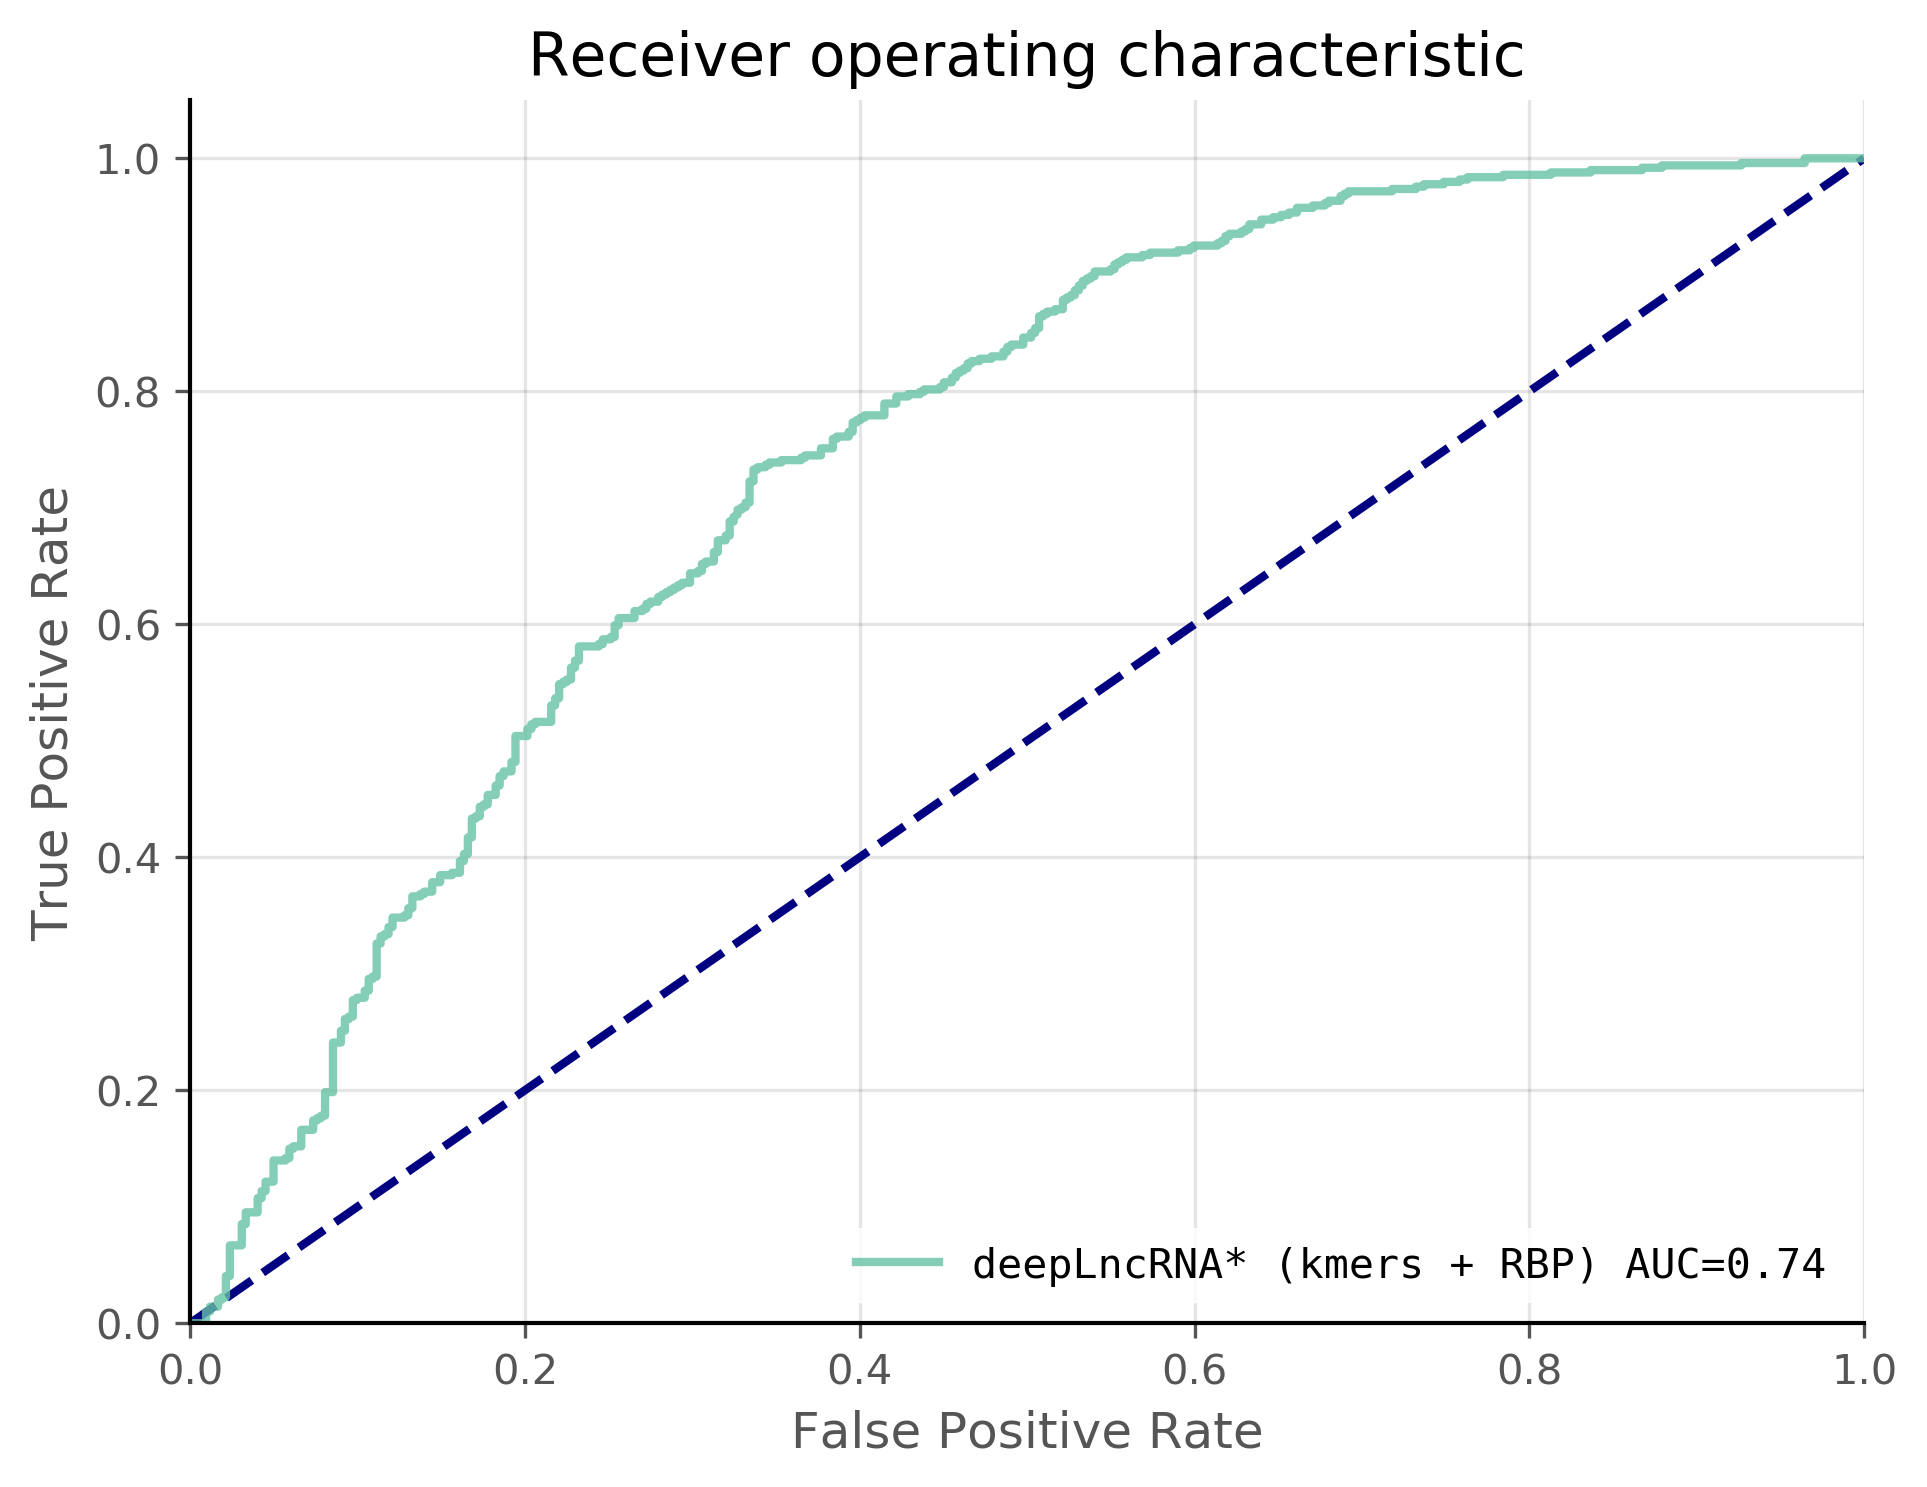

In [8]:
plotting_utils.plot_auroc({
#     "Basset (one-hot)": basset_perf[basset_best_index],
#     "fBasset (one-hot)": f_basset_perf[f_basset_best_index],
    "deepLncRNA* (kmers + RBP)": dense_model_perf[dense_best_index],
})

## Hyperparameter search for deepLncRNA

In [27]:
l1_regs = [0, 0.001, 0.01, 0.05, 0.1, 0.5]
l2_regs = [0, 0.001, 0.01, 0.05, 0.1, 0.5]
learning_rates = [0.001, 0.005, 0.01]

densenet_arg_combo_to_perf = collections.OrderedDict()
for arg_combo in tqdm.notebook.tqdm(list(itertools.product(l1_regs, l2_regs, learning_rates))):
    l1_lambda, l2_lambda, lr = arg_combo
    dense_model = DenseNet(kmer_train_data[0][0].shape[-1])
    dense_model_perf_state = pytorch_train(
        dense_model,
        kmer_train_data,
        kmer_valid_data,
        optim=lambda x: torch.optim.SGD(x, lr=lr, weight_decay=l2_lambda),  # L2 reg 1e-3
        l1_reg=l1_lambda,
        verbose=False,
    )
    densenet_arg_combo_to_perf[arg_combo] = dense_model_perf_state

In [28]:
densenet_arg_combo_to_perf_tuples = {k:v[0] for k, v in densenet_arg_combo_to_perf.items()}
densenet_arg_combo_to_model_params = {k:v[1] for k, v in densenet_arg_combo_to_perf.items()}

In [29]:
arg_combos = list(densenet_arg_combo_to_perf_tuples.keys())
# Each of these is a list of per-epoch performance
densenet_perf_tuples = [densenet_arg_combo_to_perf_tuples[k] for k in arg_combos]

In [30]:
densenet_aurocs = [max([p.auroc for p in epoch_perf_list]) for epoch_perf_list in densenet_perf_tuples]
densenet_auprcs = [max([p.auprc for p in epoch_perf_list]) for epoch_perf_list in densenet_perf_tuples]
densenet_accs = [max([p.accuracy for p in epoch_perf_list]) for epoch_perf_list in densenet_perf_tuples]

In [31]:
print(max(densenet_aurocs))
print(np.argmax(densenet_aurocs))
print(max(densenet_auprcs))
print(np.argmax(densenet_auprcs))
print(max(densenet_accs))
print(np.argmax(densenet_accs))

0.7727612871040159
23
0.7576612473951334
23
0.7194323144104804
23


In [34]:
list(densenet_arg_combo_to_perf.keys())[23]

(0.001, 0.001, 0.01)

In [35]:
densenet_best_params = (0.001, 0.001, 0.01)
l1_lambda, l2_lambda, lr = densenet_best_params
densenet_best_params

(0.001, 0.001, 0.01)

In [45]:
dense_model = DenseNet(kmer_train_data[0][0].shape[-1])
dense_model_perf, dense_model_state_dicts = pytorch_train(
    dense_model,
    kmer_train_data,
    kmer_valid_data,
    optim=lambda x: torch.optim.SGD(x, lr=lr, weight_decay=l2_lambda),  # L2 reg 1e-3
    l1_reg=l1_lambda,
)

Epoch 0/30
Validation accuracy: 0.6244541484716157
Validation F1:       0.5875299760191847
Validation AUPRC:    0.6895280702361601
Validation AUROC:    0.7251232803116066
Validation CE loss:  0.6804499065911782
Runtime for epoch: 7.875820159912109
Epoch 1/30
Validation accuracy: 0.6932314410480349
Validation F1:       0.7279767666989352
Validation AUPRC:    0.6984954041123251
Validation AUROC:    0.7319372757449585
Validation CE loss:  0.6776540320485559
Runtime for epoch: 7.735463619232178
Epoch 2/30
Validation accuracy: 0.6844978165938864
Validation F1:       0.7493495229835214
Validation AUPRC:    0.7117143938265984
Validation AUROC:    0.743457029376211
Validation CE loss:  0.6724091065455623
Runtime for epoch: 7.735238552093506
Epoch 3/30
Validation accuracy: 0.6724890829694323
Validation F1:       0.7572815533980581
Validation AUPRC:    0.7087437829833672
Validation AUROC:    0.7390582727325057
Validation CE loss:  0.67167882901786
Runtime for epoch: 7.711679935455322
Epoch 4/30


5 0.7194323144104804


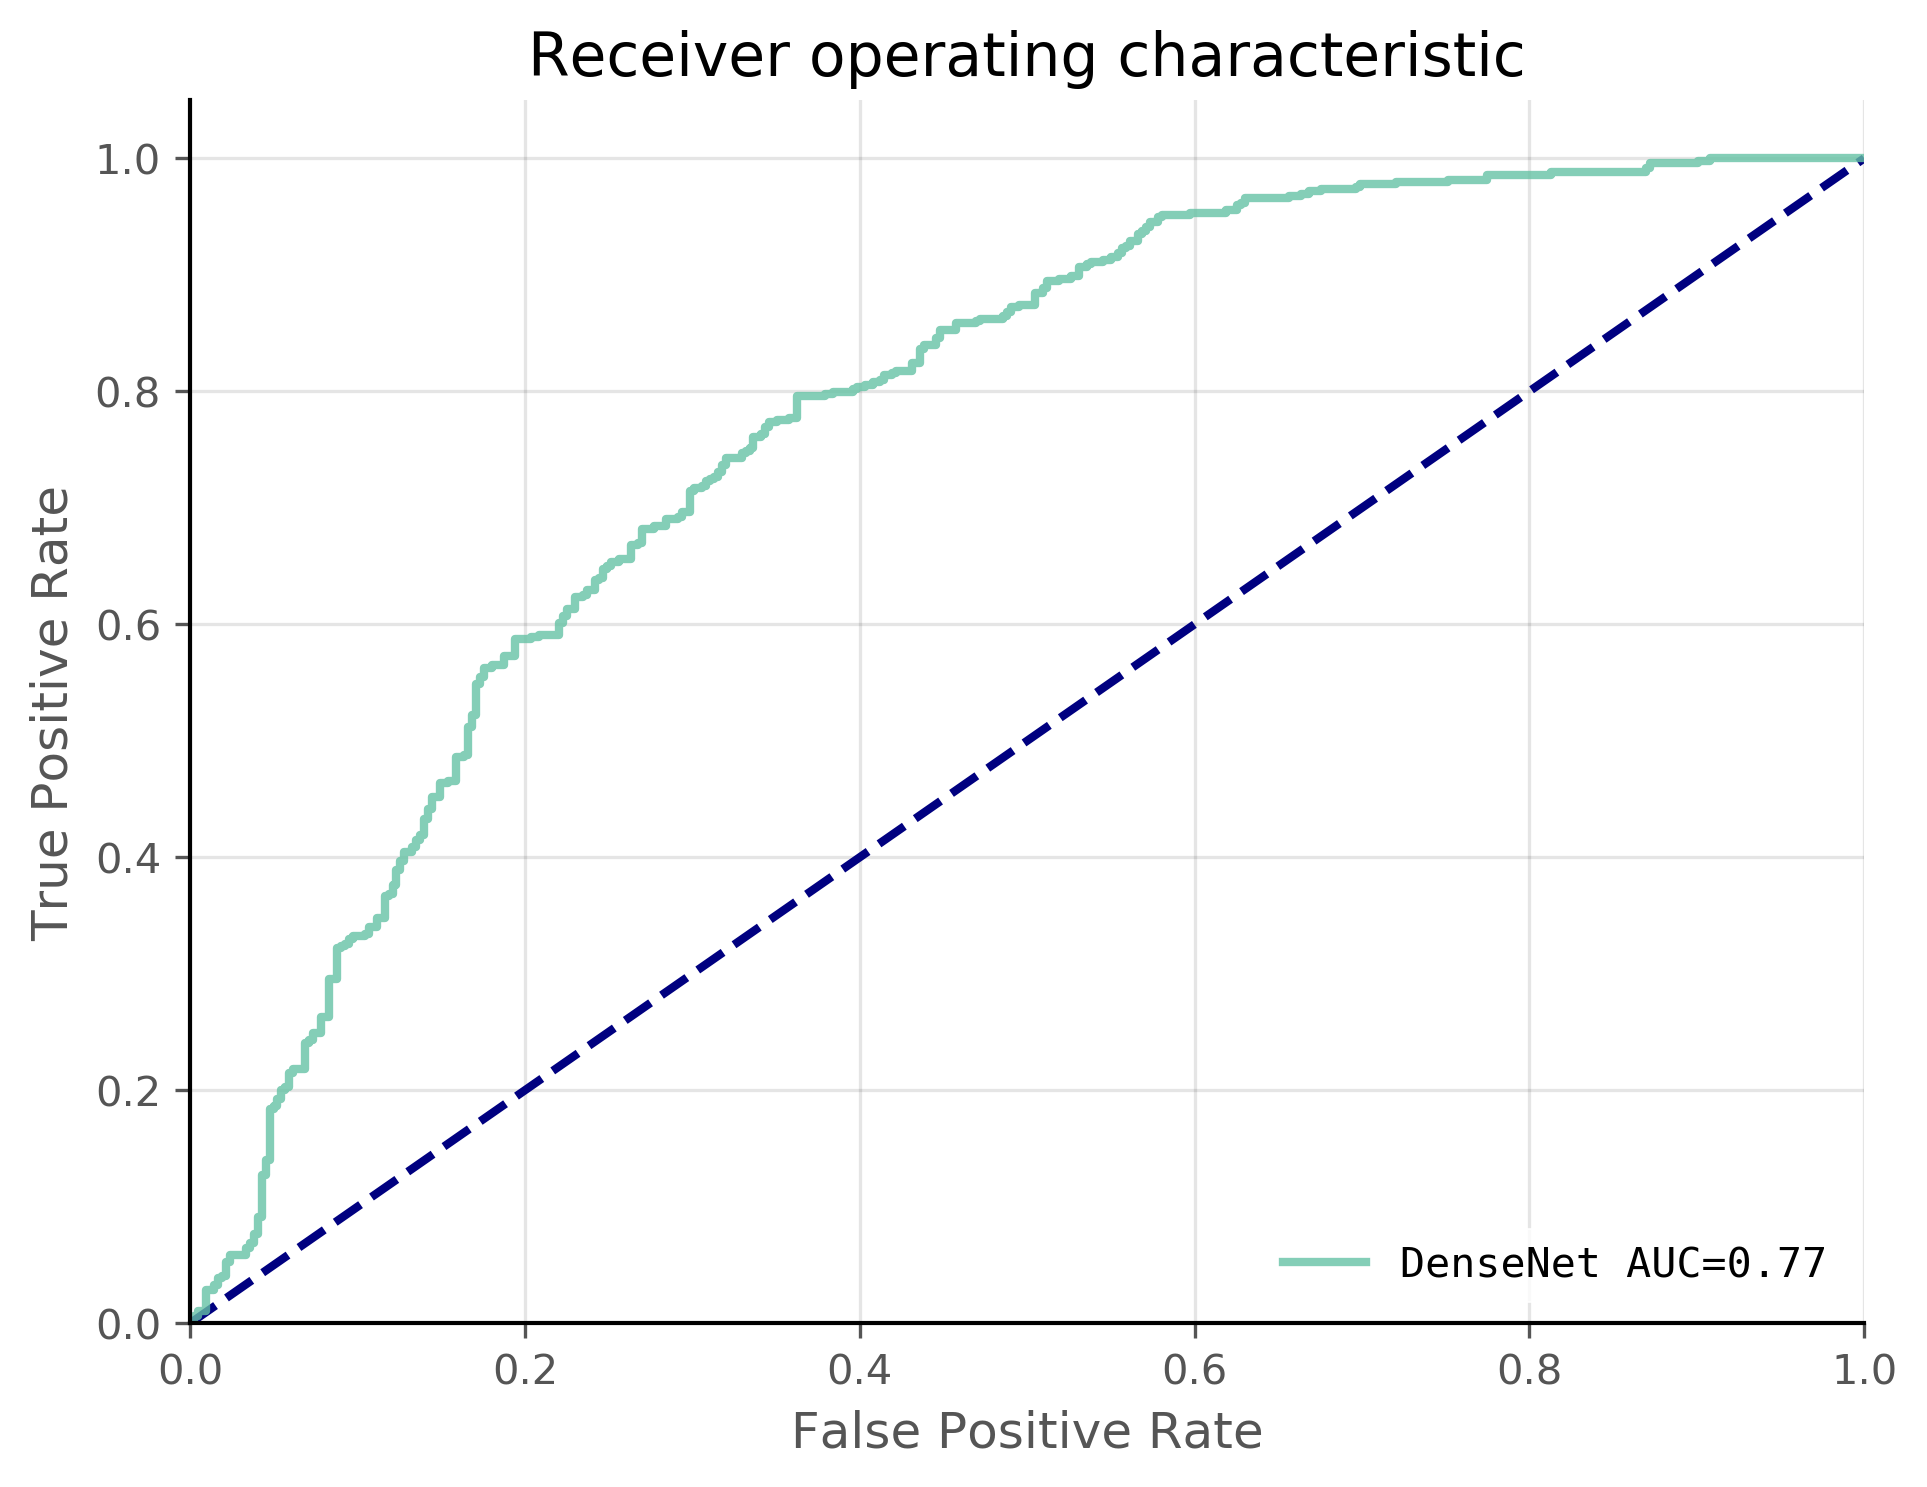

In [46]:
# Select by best validation accuracy
dense_best_index = np.argmax([p.accuracy for p in dense_model_perf])  # Check max AUROC
print(dense_best_index, max([p.accuracy for p in dense_model_perf]))

importlib.reload(plotting_utils)
plotting_utils.plot_auroc({"DenseNet": dense_model_perf[dense_best_index]})
with open("densenet.valid.perf", 'wb') as sink:
    pickle.dump(dense_model_perf[dense_best_index], sink)

In [47]:
# Plot test results
dense_model.load_state_dict(dense_model_state_dicts[dense_best_index])
dense_model.eval()
dense_model_test_perf = pytorch_eval(dense_model, kmer_test_data)

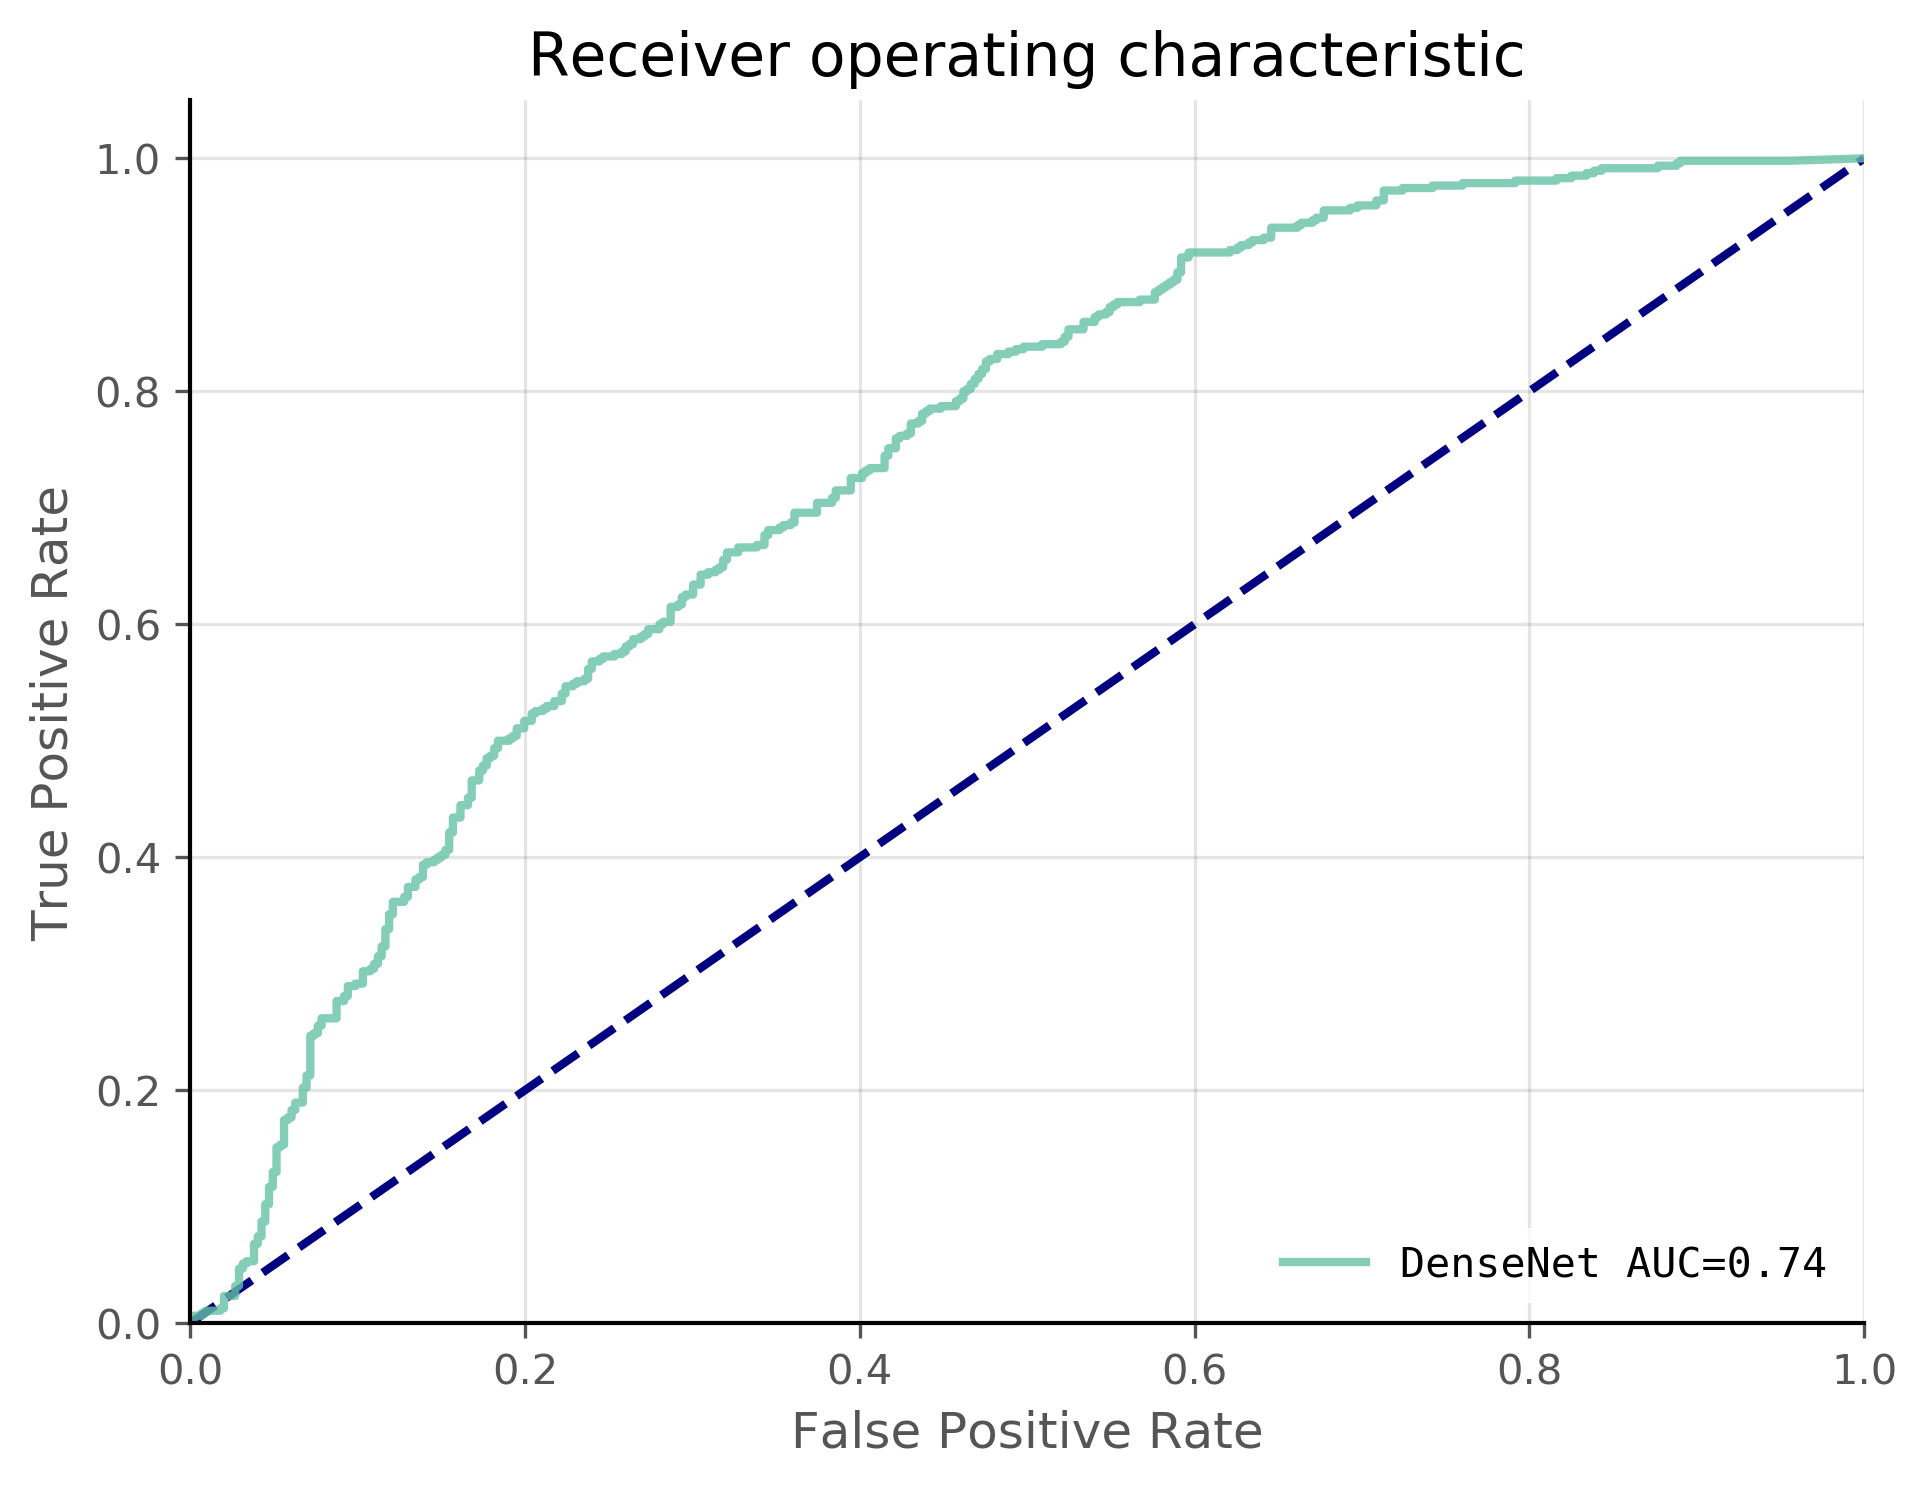

In [48]:
plotting_utils.plot_auroc({"DenseNet": dense_model_test_perf})
with open("densenet.test.perf", 'wb') as sink:
    pickle.dump(dense_model_test_perf, sink)

## Heatmap

In [49]:
importlib.reload(data_loader)
kmer_valid_data_array = data_loader.load_data_as_np(kmer_valid_data, progress_bar=False)
kmer_test_data_array = data_loader.load_data_as_np(kmer_test_data, progress_bar=False)
kmer_train_data_array = data_loader.load_data_as_np(kmer_train_data, progress_bar=False)

In [50]:
kmer_valid_log2fc = kmer_valid_data.deseq_table_subsetted['log2FoldChange']
# idx_valid_label_sort = np.argsort(parted_kmer_valid_data[1])
idx_valid_label_sort = np.argsort(kmer_valid_log2fc)

In [51]:
valid_data_sorted = (kmer_valid_data_array[0][idx_valid_label_sort, :], kmer_valid_data_array[1][idx_valid_label_sort])
idx_test_label_sort = np.argsort(kmer_test_data_array[1])
test_data_sorted = (kmer_test_data_array[0][idx_test_label_sort, :], kmer_test_data_array[1][idx_test_label_sort])

valid_data_sorted_preds = dense_model(torch.from_numpy(valid_data_sorted[0]).to(DEVICE))[0].detach().cpu().numpy()
valid_data_sorted_preds = np.hstack([1.0 - valid_data_sorted_preds, valid_data_sorted_preds])
assert np.all(np.isclose(np.sum(valid_data_sorted_preds, axis=1), 1.0))
valid_data_sorted_preds

array([[0.5088717 , 0.49112836],
       [0.42653954, 0.57346046],
       [0.511036  , 0.48896402],
       ...,
       [0.5248934 , 0.47510657],
       [0.40153724, 0.59846276],
       [0.48297113, 0.51702887]], dtype=float32)

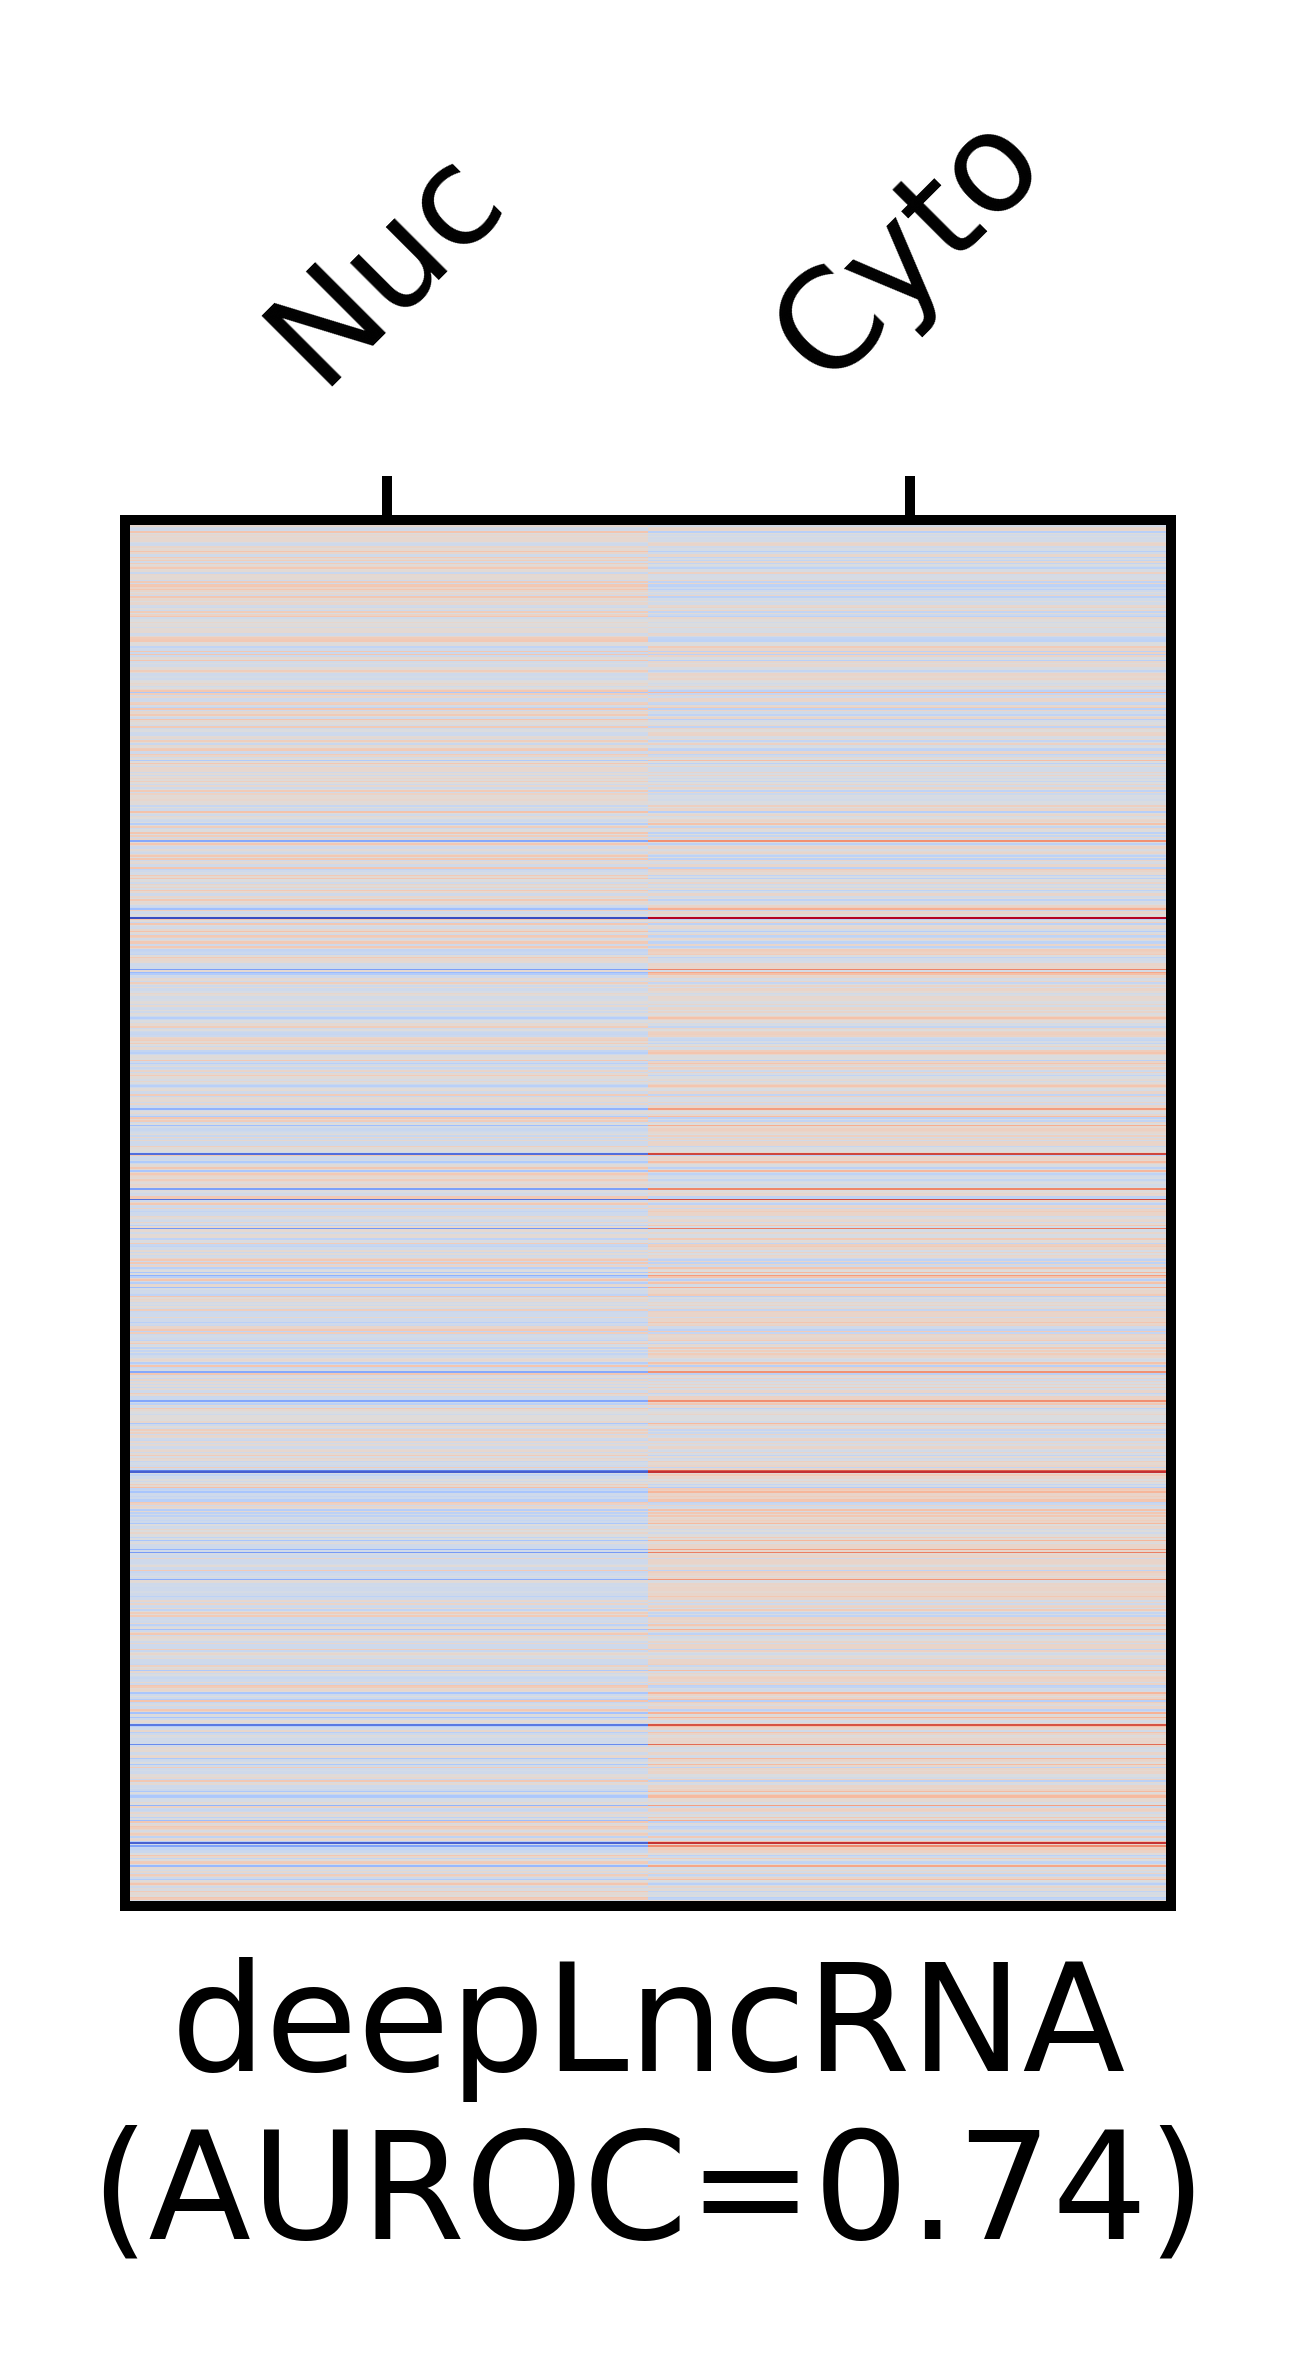

In [57]:
fig, ax = plt.subplots(dpi=900, figsize=(1.5, 2))
cax = ax.matshow(valid_data_sorted_preds, aspect='auto', cmap=plt.cm.coolwarm)
# cax = ax.matshow(np.vstack((1.0 - valid_data_sorted[1], valid_data_sorted[1])), aspect='auto', cmap=plt.cm.coolwarm)
ax.set_xticklabels(['', 'Nuc', 'Cyto'], rotation=45)
ax.set_yticklabels([])
ax.tick_params(bottom=False, left=False)
ax.set(
    xlabel=f"deepLncRNA\n(AUROC={dense_model_test_perf.auroc:.2f})"
)
ax.grid(False)
# cbar = fig.colorbar(cax)
fig.savefig(os.path.join(PLOT_DIR, "nuc_cyto_heatmap_deeplncrna.pdf"), bbox_inches='tight')
fig.show()

NameError: name 'test_data_sorted_preds' is not defined

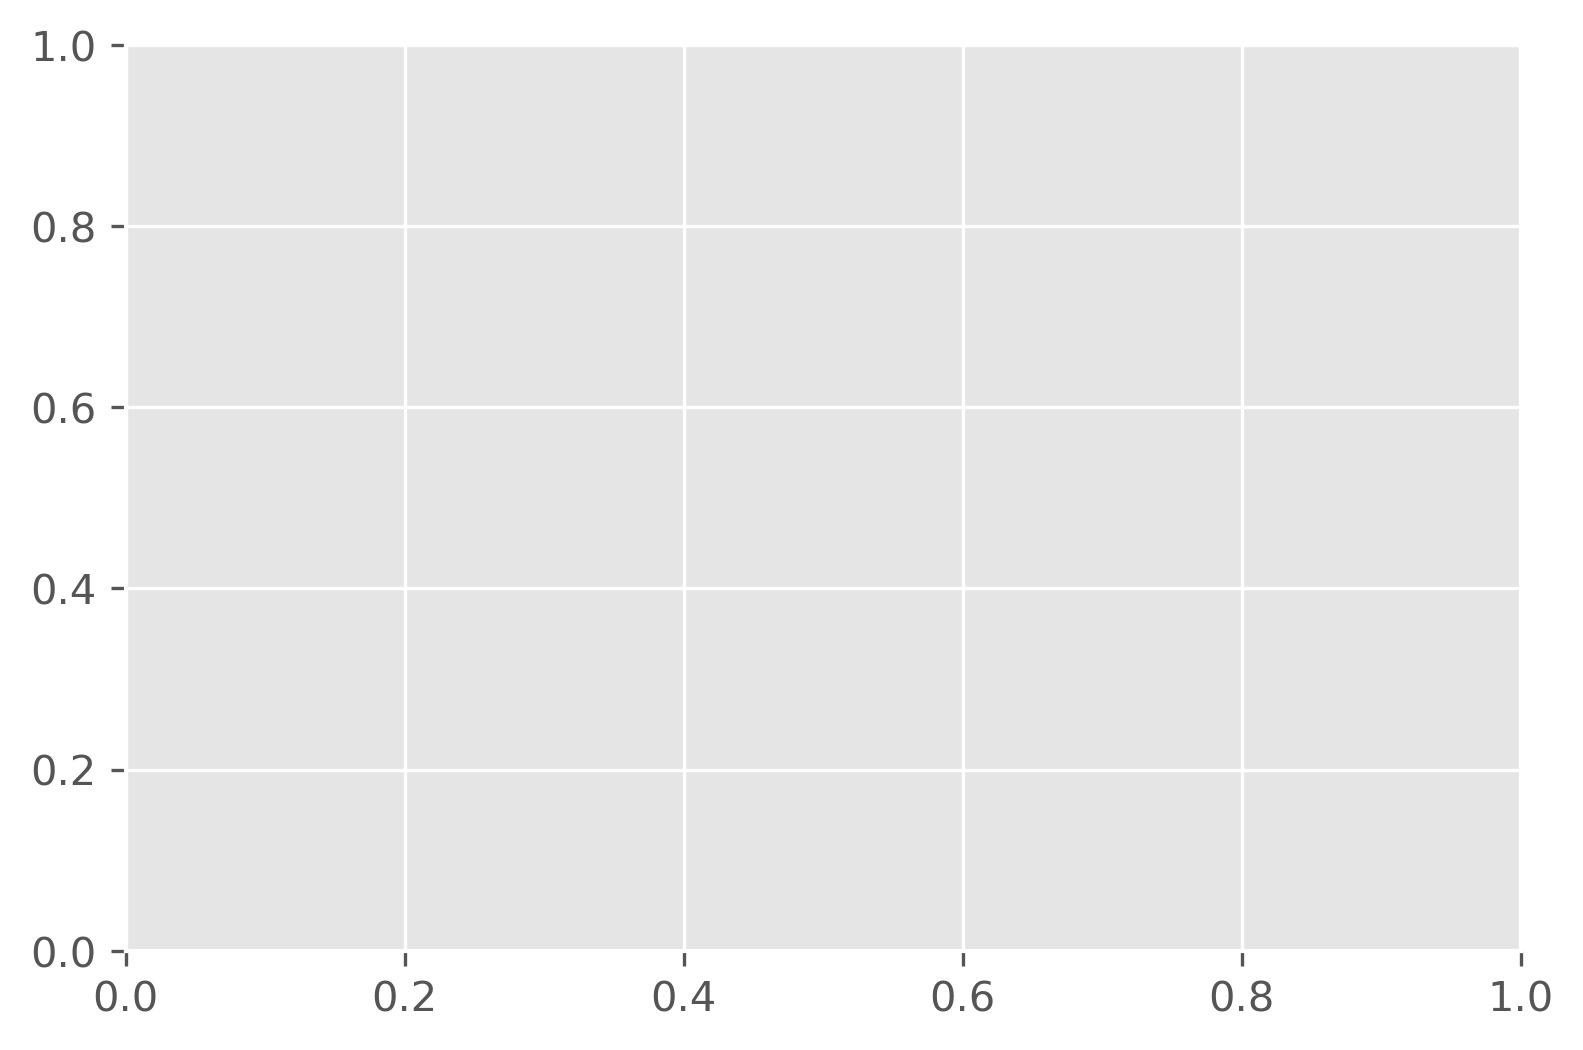

In [43]:
fig, ax = plt.subplots(dpi=300)
ax.hist(
    test_data_sorted_preds[:, 1].flatten(),
#     bins=35,
    bins=np.arange(0.0, 1.0, 0.025),
)
ax.axvline(0.5, color='tab:blue', alpha=0.5, linestyle='--')
ax.set(
    title='DeepLncRNA predicted probabilities histogram',
    xlabel='p',
)
fig.show()